# Analyzing Neural Time Series Data: Chapter 18

### Time-Frequency Power and Baseline Normalizations

Converted from MATLAB to Python by Andrew J. Graves on 04/30/20

In [1]:
# Get matplotlib magic
%matplotlib notebook 

# Import modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

### Figure 18.1

<IPython.core.display.Javascript object>


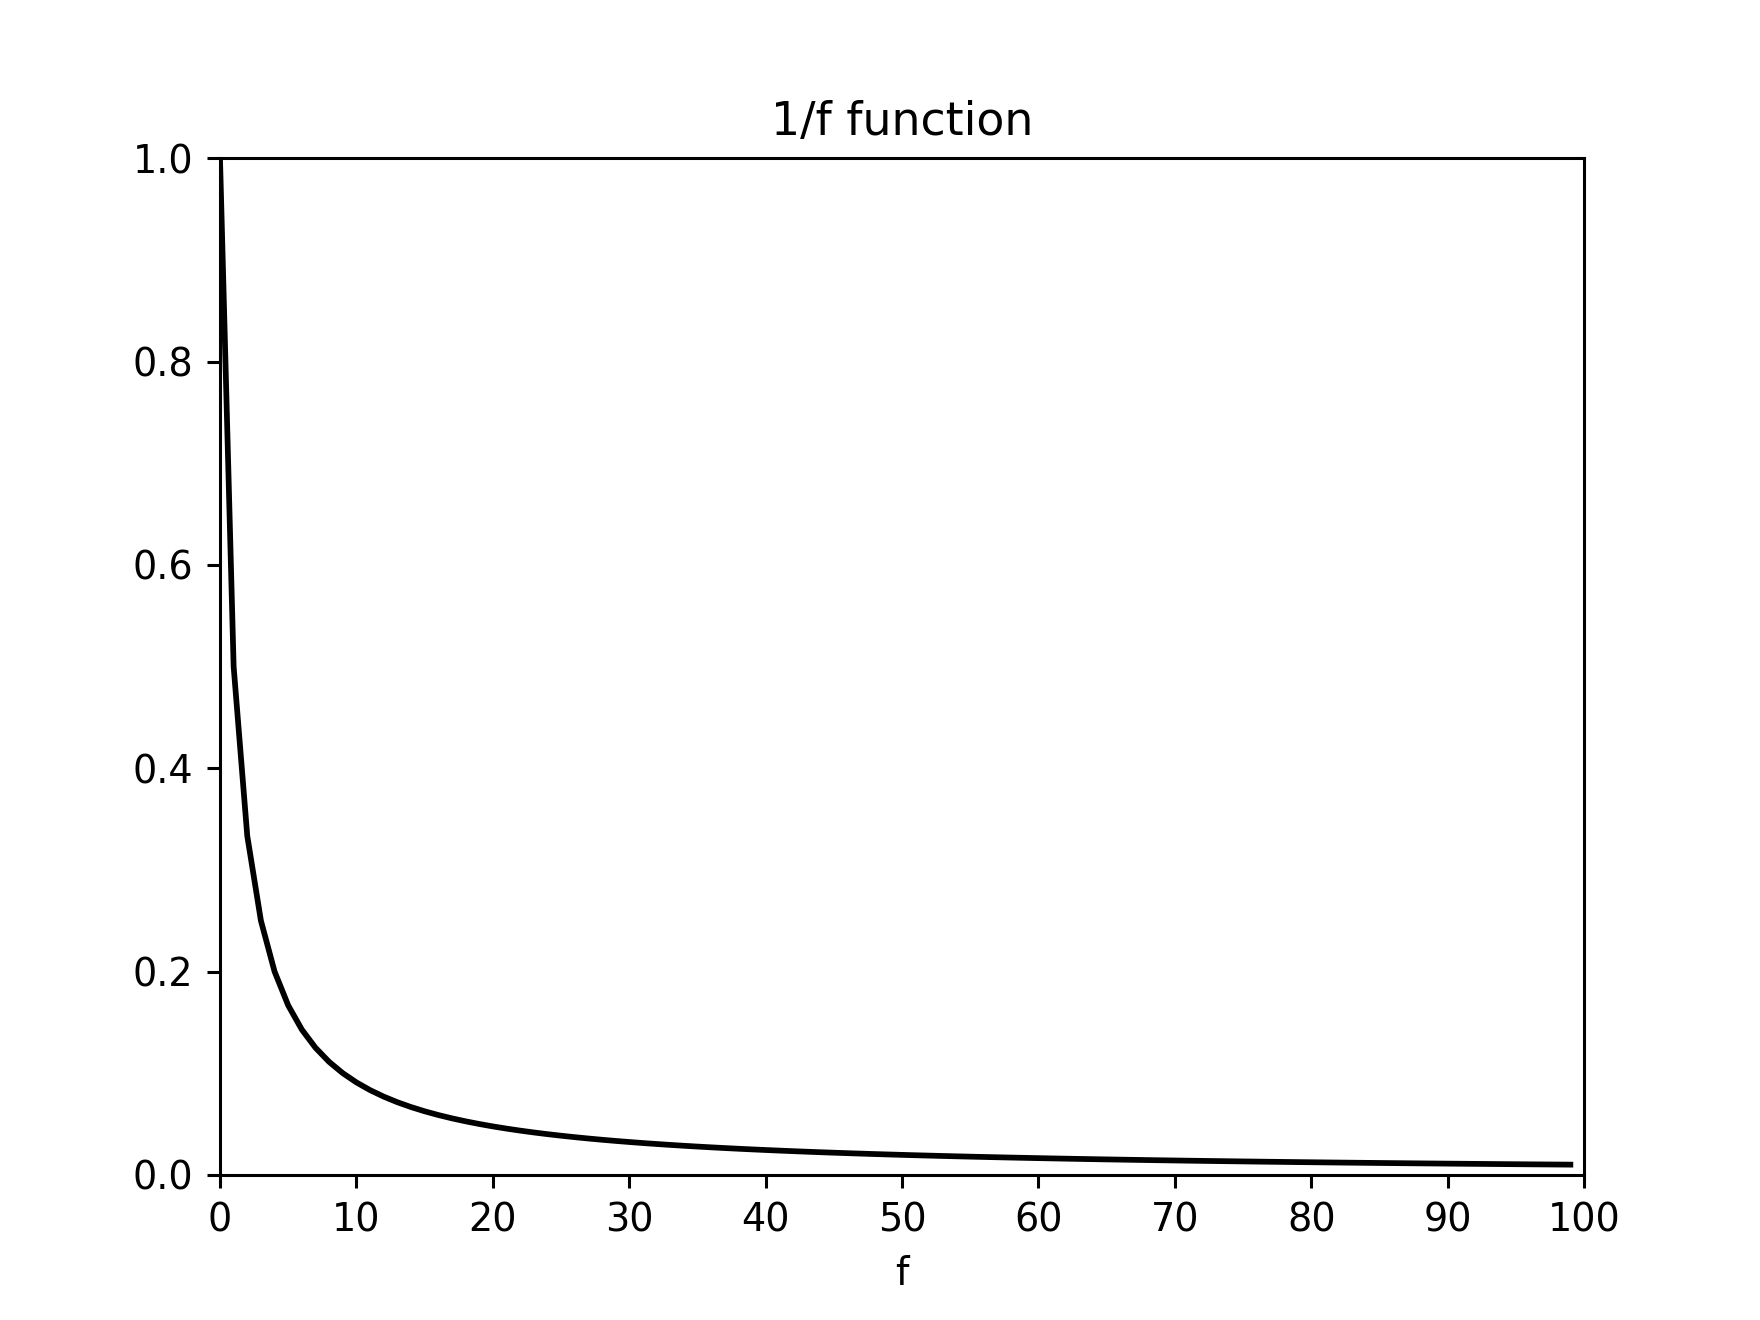

In [2]:
c = 1 # Set constant
x = 1 # Set exponent 

plt.figure()
plt.plot(c / np.arange(1, 101) ** x, color='black')
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('f')
plt.xticks(np.arange(0, 101, 10))
plt.title('1/f function')
plt.show()

### Figure 18.2

<IPython.core.display.Javascript object>


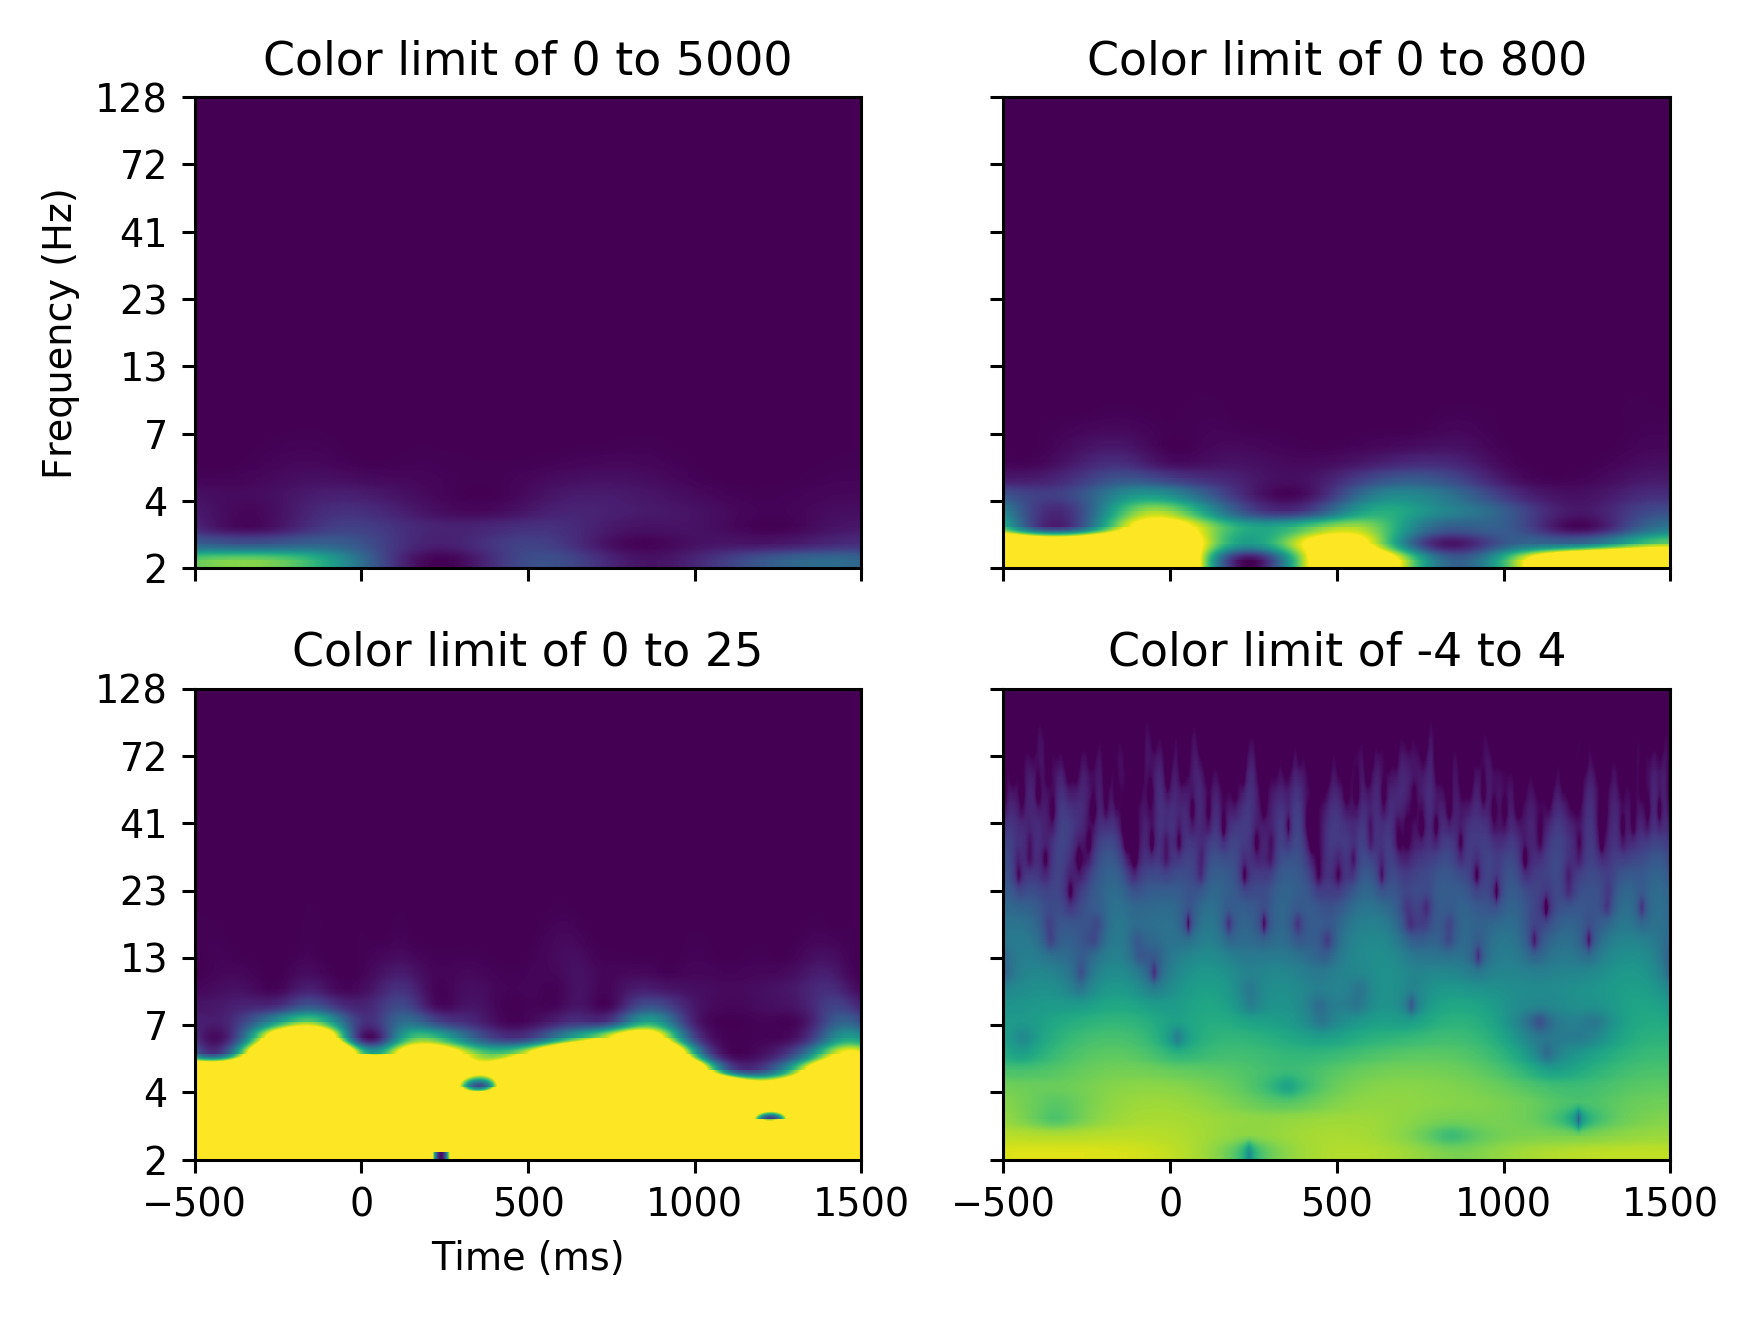

In [3]:
# Wavelet parameters
min_freq = 2
max_freq = 128
n_freqs = 30

time = time_series(samp_rate)
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
half_of_wavelet = (len(time) - 1) // 2

# FFT parameters (use next power of 2)
n_wavelet = len(time)
n_data = np.shape(eeg_data)[1]
n_conv = n_wavelet + n_data - 1
n_conv_pow2 = pow(2, np.ceil(np.log2(np.abs(n_conv))))
n_cycles = 4

# FFT of data
fft_data = np.fft.fft(np.squeeze(eeg_data[22, :, 0]), n_conv_pow2)

# Initialize output time-frequency data
tf_data = np.zeros([len(freqs), n_data])

for i in range(len(freqs)):
    
    # Create wavelet and compute FFT
    wavelet = (np.pi * freqs[i] * np.sqrt(np.pi))**-.5 * get_sine_wave(
        freqs[i], samp_rate, complex_wave=True) * gauss_win(
        freqs[i], samp_rate, n_cycles, normalize=True)
    fft_wavelet = np.fft.fft(wavelet, n_conv_pow2)
    
    # Run convolution
    temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_data, n_conv_pow2)
    temp_conv_res_fft = temp_conv_res_fft[0:n_conv]
    conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
    
    # Place power data into time-frequency matrix
    tf_data[i, :] = np.abs(conv_res_fft) ** 2
    
# Plot results
y_tick_skip = np.arange(1, n_freqs, 4)
clims = [[0, 5000], [0, 800], [0, 25], [-4, 4]]

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

j = 0
for i in ax.flatten():
    plot_data = tf_data
    if j == 3:
        plot_data = np.log10(tf_data)
    i.imshow(plot_data, aspect='auto', 
             extent=[min(eeg_time), max(eeg_time), 30, 1],
             clim=(clims[j][0], clims[j][1]),
             interpolation='hamming'
            )
    i.set_xlim([-500, 1500])
    i.set_yticks(y_tick_skip)
    i.set_yticklabels([round(x) for x in freqs[y_tick_skip].tolist()])
    i.invert_yaxis()
    i.set_title('Color limit of ' + str(clims[j][0]) + ' to ' + str(clims[j][1]))
    j += 1

ax[0, 0].set_ylabel('Frequency (Hz)')
ax[1, 0].set_xlabel('Time (ms)')
fig.tight_layout()

### Figure 18.3

Let $t$ be time, $f$ frequency:

Decibel (dB) conversion using baseline normalization stems from the following ratio:

$$\textrm{dB}_{tf} = 10log_{10}\frac{\textrm{activity}_{tf}}{\overline{\textrm{baseline}}_{f}}$$

<IPython.core.display.Javascript object>


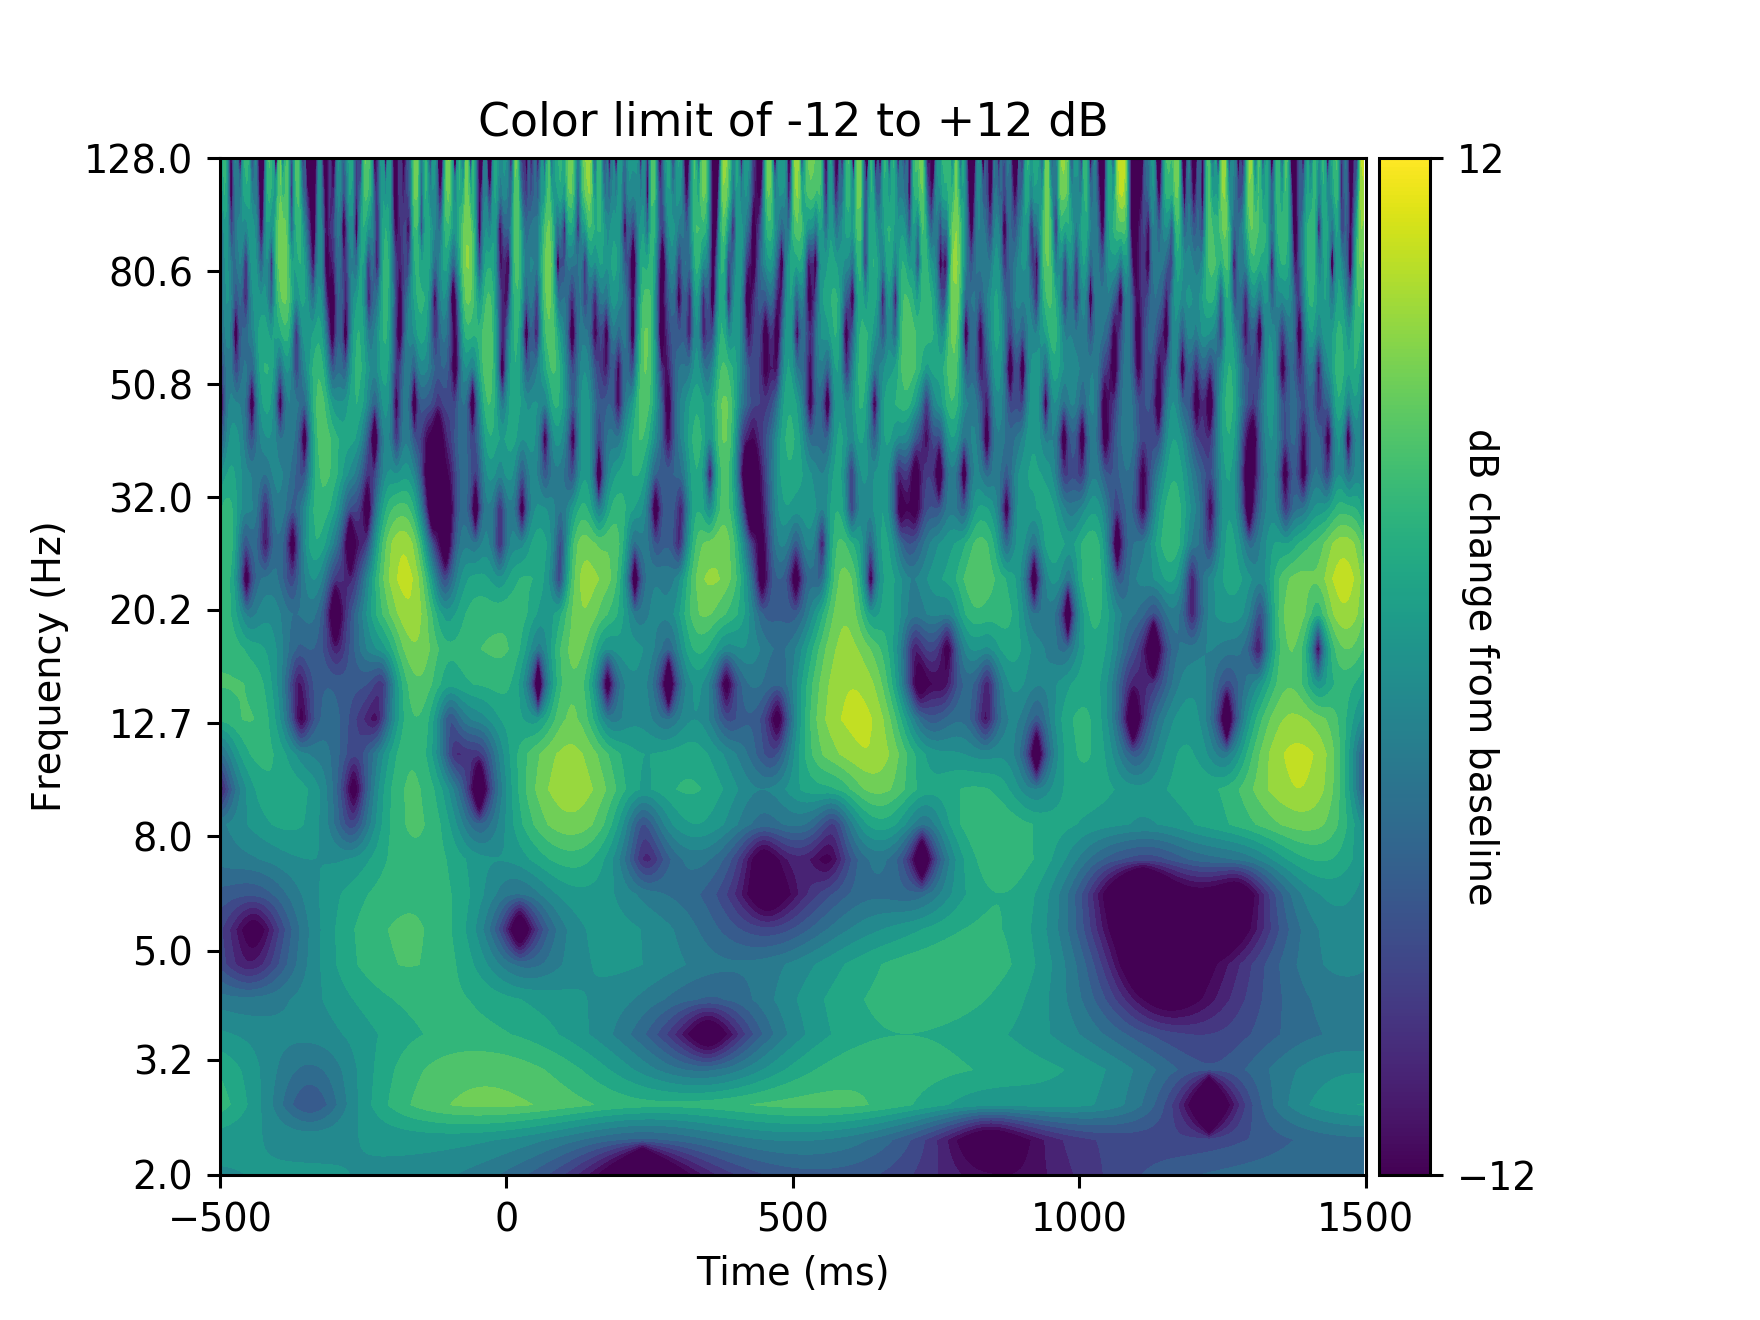

In [4]:
# Define baseline period
baseline = [-500, -200] # ms
time_start = eeg_time - baseline[0]
time_end = eeg_time - baseline[1]

# Convert baseline window time to indices
base_idx_start = np.squeeze(np.where(time_start == np.min(np.abs(time_start))))
base_idx_end = np.squeeze(np.where(time_end == np.min(np.abs(time_end)))) + 1

# dB-correct
baseline_power = np.mean(tf_data[:, base_idx_start:base_idx_end], 1)
db_converted = 10 * np.log10(tf_data / baseline_power.reshape(np.shape(baseline_power)[0], 1))

yticks = np.round(np.logspace(np.log10(np.min(freqs)), np.log10(np.max(freqs)), 10), 1)

fig, ax = plt.subplots()
plt.contourf(eeg_time, freqs, db_converted, levels=40, vmin=-12, vmax=12)
plt.xlim([-500, 1500])
plt.yscale('log')
plt.xticks(np.linspace(-500, 1500, 5))
plt.yticks(yticks, labels=yticks)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Color limit of -12 to +12 dB')

m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-12, vmax=12))
cbar = fig.colorbar(m, pad=.01)
cbar.set_ticks([-12, 12])
cbar.set_label('dB change from baseline', rotation=270, labelpad=-10)
plt.minorticks_off()
plt.show()

### Figure 18.4

<IPython.core.display.Javascript object>


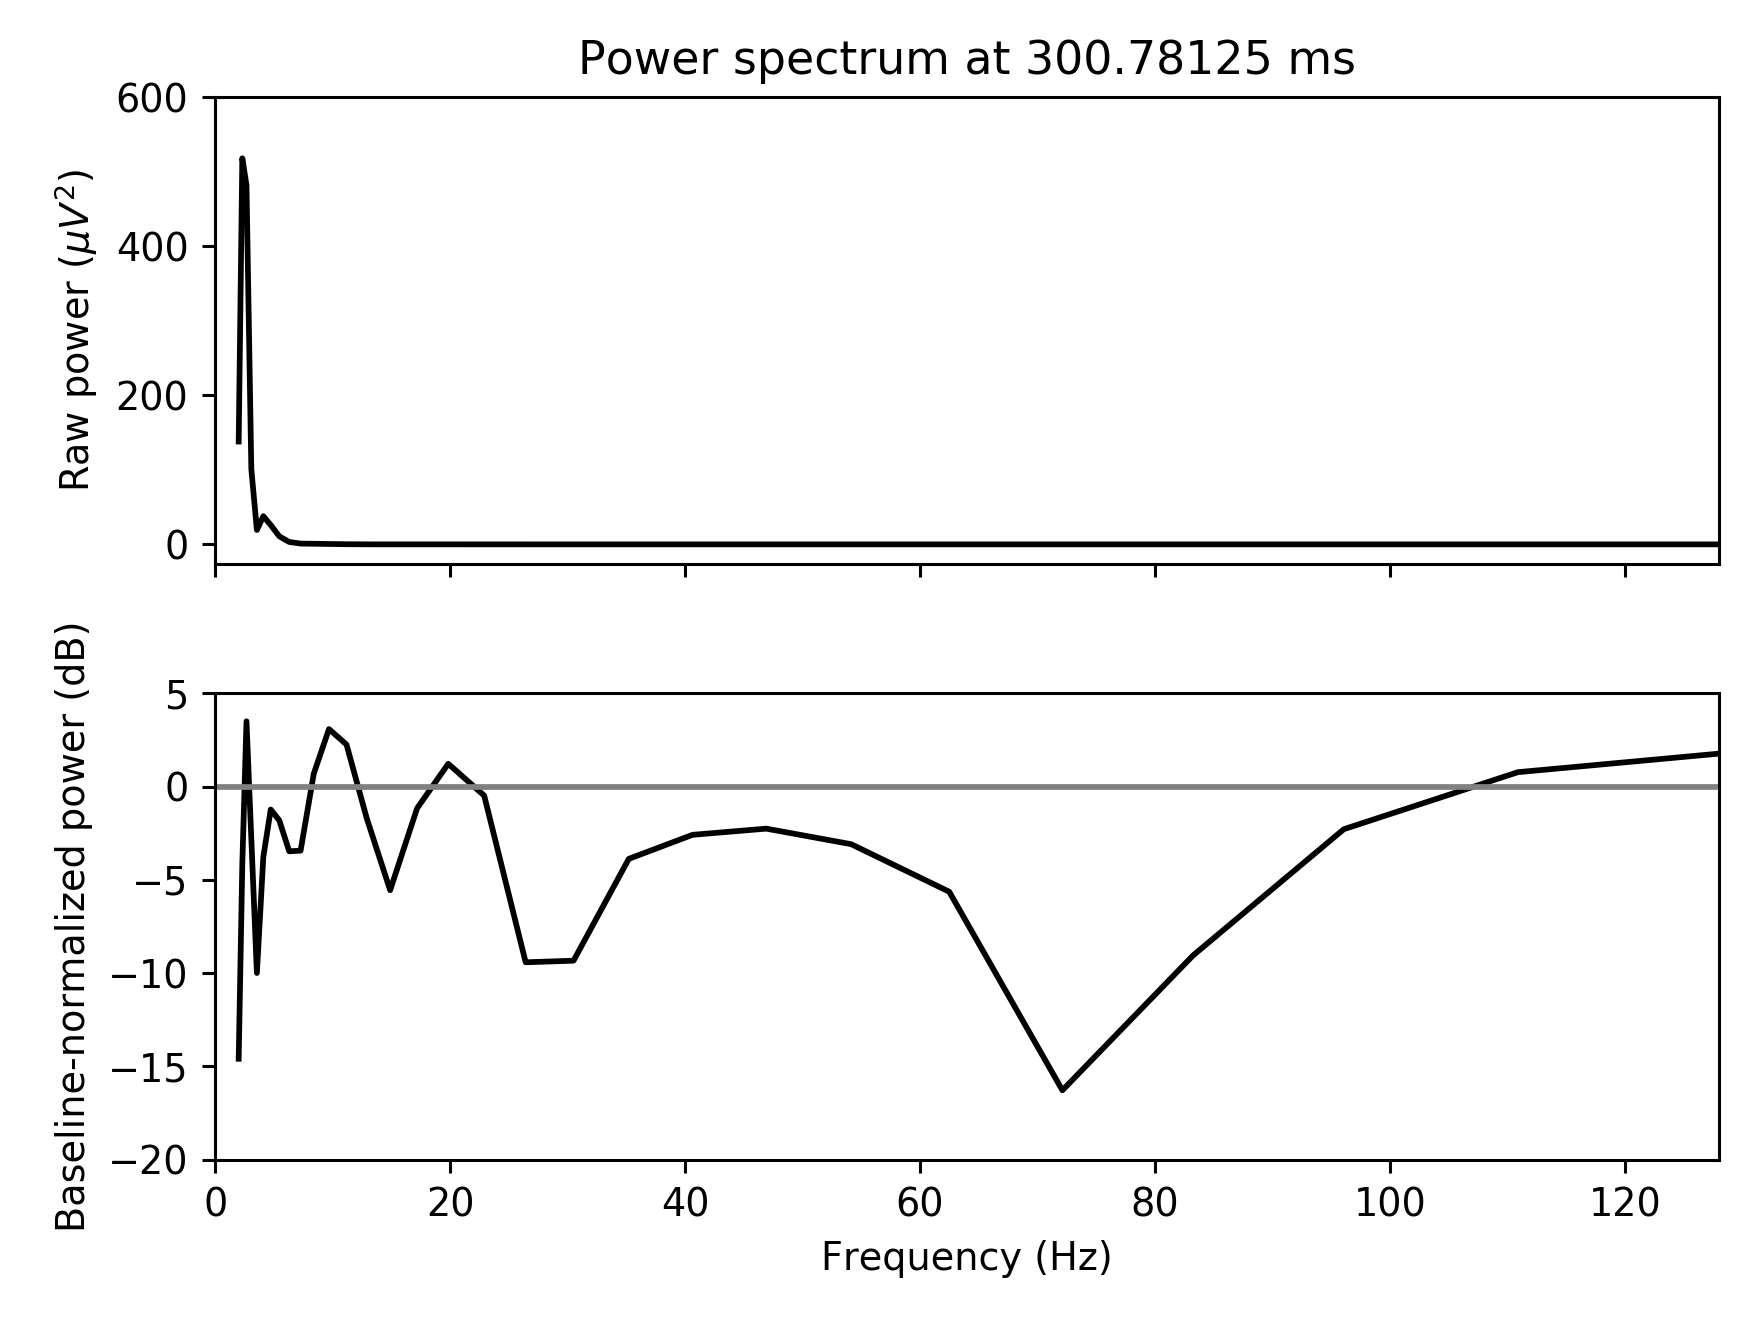

In [5]:
time_to_plot = 300
time_shift = eeg_time - time_to_plot

time_idx = np.squeeze(np.where(time_shift == np.min(np.abs(time_shift))))

# Plot frequencies
fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(freqs, np.squeeze(tf_data[:, time_idx]), color='black')
ax[0].set_yticks(np.linspace(0, 600, 4))
ax[0].set_title('Power spectrum at ' + str(eeg_time[time_idx]) + ' ms')
ax[0].set_ylabel(r'Raw power ($\mu$$V^2$)')

ax[1].plot(freqs, np.squeeze(db_converted[:, time_idx]), color='black')
ax[1].axhline(y=0, color='grey')
ax[1].set_xlim(0, np.max(freqs))
ax[1].set_yticks(np.linspace(-20, 5, 6))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Baseline-normalized power (dB)')

fig.tight_layout()

### Figure 18.6

Percent change ($\%\Delta$) and the $Z$-transformation are alternative normalization procedures defined as:

$$\%\Delta = 100\frac{\textrm{activity}_{tf} - \overline{\textrm{baseline}}_{f}}{\overline{\textrm{baseline}}_{f}}$$

Let $n$ be the number of timepoints:

$$Z_{tf} = \frac{\textrm{activity}_{tf} - \overline{\textrm{baseline}}_{f}}{\sqrt{(n - 1)^{-1}\Sigma_{i=1}^n(\textrm{baseline}_{if} - \overline{\textrm{baseline}}_{f})^2}}$$

<IPython.core.display.Javascript object>


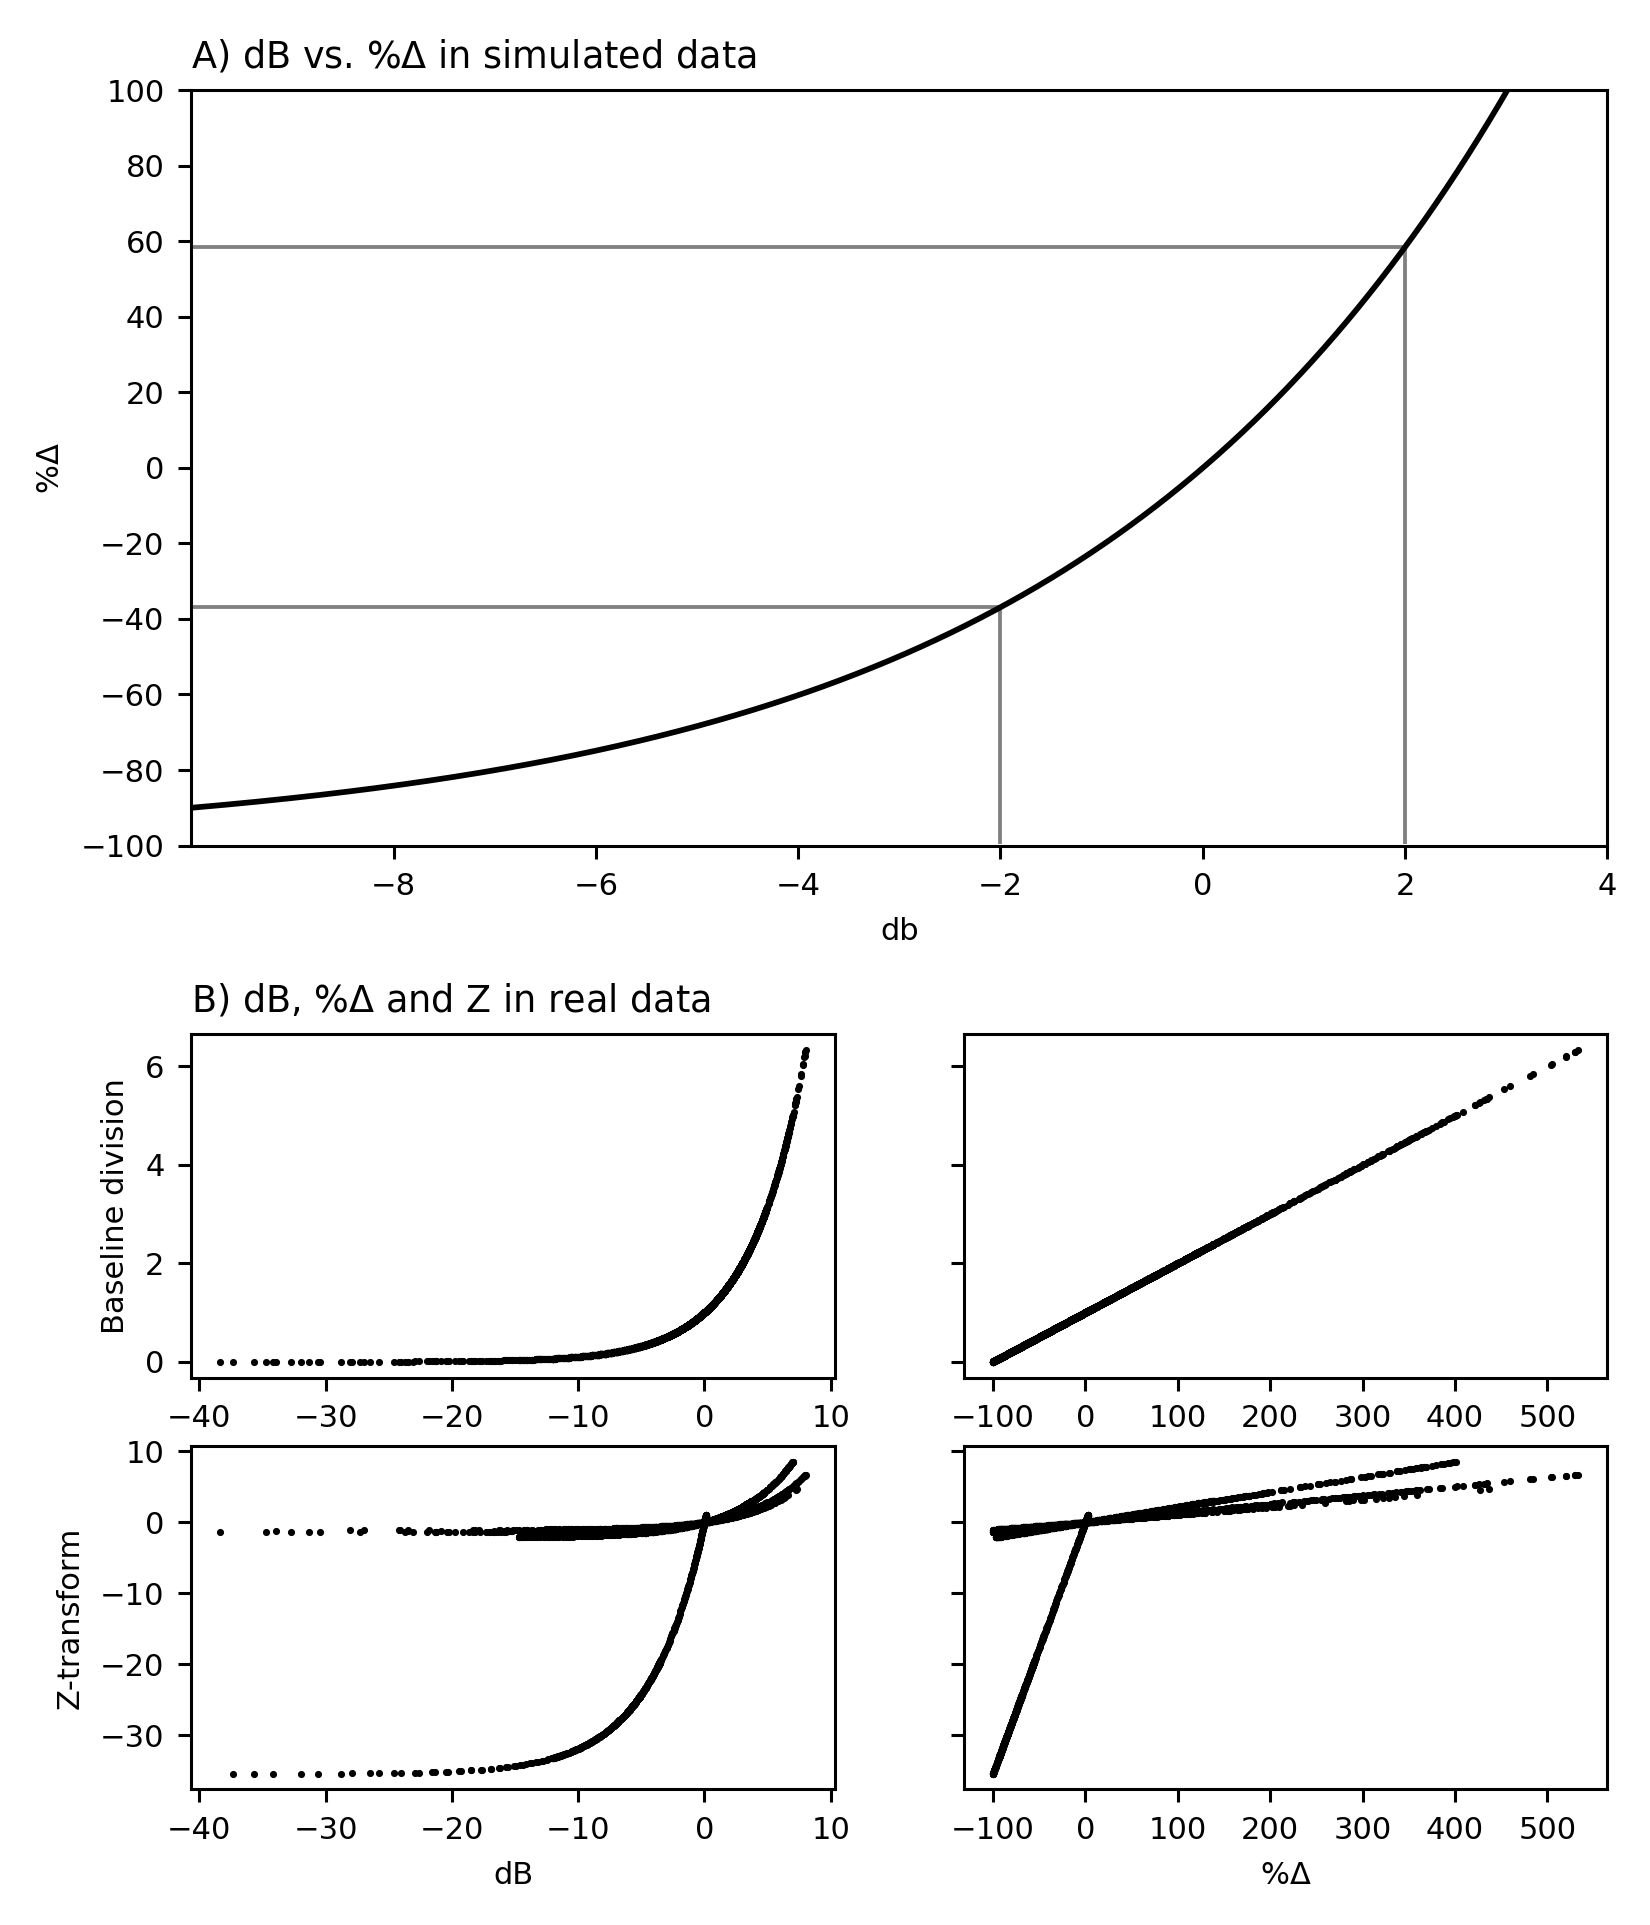

In [6]:
# Note: I flipped some of the axes in Grid B to facilitate a better data-to-ink ratio

plt.rc('font', size=8)

# Set the figure and grid
fig = plt.figure(figsize=(6,7))
full_grid = fig.add_gridspec(4, 4)

# Set the subgrids
grid_A = full_grid[0:2, :].subgridspec(1, 1)
grid_B = full_grid[2:, :].subgridspec(2, 2)

activity = np.arange(1, 20 + .001, .01)
baseline = 10

# Grid A ----------

# Decibels
db = 10 * np.log10(activity / baseline)
# Percent change
pc = 100 * (activity - baseline) / baseline

idx_2 = np.where((db - 2) == np.min(np.abs(db - 2)))
idx_neg2 = np.where((db - -2) == np.min(np.abs(db - -2)))

ax_A = fig.add_subplot(grid_A[0, 0])
ax_A.plot(db, pc, color='black')
ax_A.hlines(y=[pc[idx_neg2], pc[idx_2]], 
            xmin=ax_A.get_xlim()[0], 
            xmax=[-2, 2], 
            linewidth=1, color='grey')
ax_A.vlines(x=[-2, 2], 
            ymin=ax_A.get_ylim()[0], 
            ymax=[pc[idx_neg2], pc[idx_2]], 
            linewidth=1, color='grey')
ax_A.set_xlim([min(db), max(db)])
ax_A.set_ylim([min(pc), max(pc)])
ax_A.set_xticks(np.arange(-8, 5, 2))
ax_A.set_yticks(np.arange(-100, 101, 20))
ax_A.set_xlabel('db')
ax_A.set_ylabel(r'$\%\Delta$')
ax_A.set_title(r'A) dB vs. $\%\Delta$ in simulated data', loc='left')

# Grid B ----------

# Percent change
baseline_power_rs = baseline_power.reshape(baseline_power.shape[0], 1)
pct_change = 100 * ((tf_data - baseline_power_rs) / baseline_power_rs)
baseline_div = tf_data / baseline_power_rs

# Z transform
std_rs = np.std(tf_data[:, base_idx_start:base_idx_end], 1, ddof=1).reshape(baseline_power.shape[0], 1)
baseline_z = (tf_data - baseline_power_rs) / std_rs

sub = tf_data.shape[0]
plt_db = db_converted[0:sub:5].flatten(order='F')
plt_pct = pct_change[0:sub:5].flatten(order='F')
plt_base_div = baseline_div[0:sub:5].flatten(order='F')
plt_z = baseline_z[0:sub:5].flatten(order='F')

ax_B00 = fig.add_subplot(grid_B[0, 0])
ax_B00.scatter(plt_db, plt_base_div, s=.75, color='black')
ax_B00.set_ylabel('Baseline division')
ax_B00.set_title(r'B) dB, $\%\Delta$ and Z in real data', loc='left')

ax_B01 = fig.add_subplot(grid_B[0, 1])
ax_B01.scatter(plt_pct, plt_base_div, s=.75, color='black')
ax_B01.set_yticklabels([])

ax_B10 = fig.add_subplot(grid_B[1, 0])
ax_B10.scatter(plt_db, plt_z, s=.75, color='black')
ax_B10.set_xlabel('dB')
ax_B10.set_ylabel('Z-transform')

ax_B11 = fig.add_subplot(grid_B[1, 1])
ax_B11.scatter(plt_pct, plt_z, s=.75, color='black')
ax_B11.set_yticklabels([])
ax_B11.set_xlabel(r'$\%\Delta$')

full_grid.tight_layout(fig)

### Figure 18.7

<IPython.core.display.Javascript object>


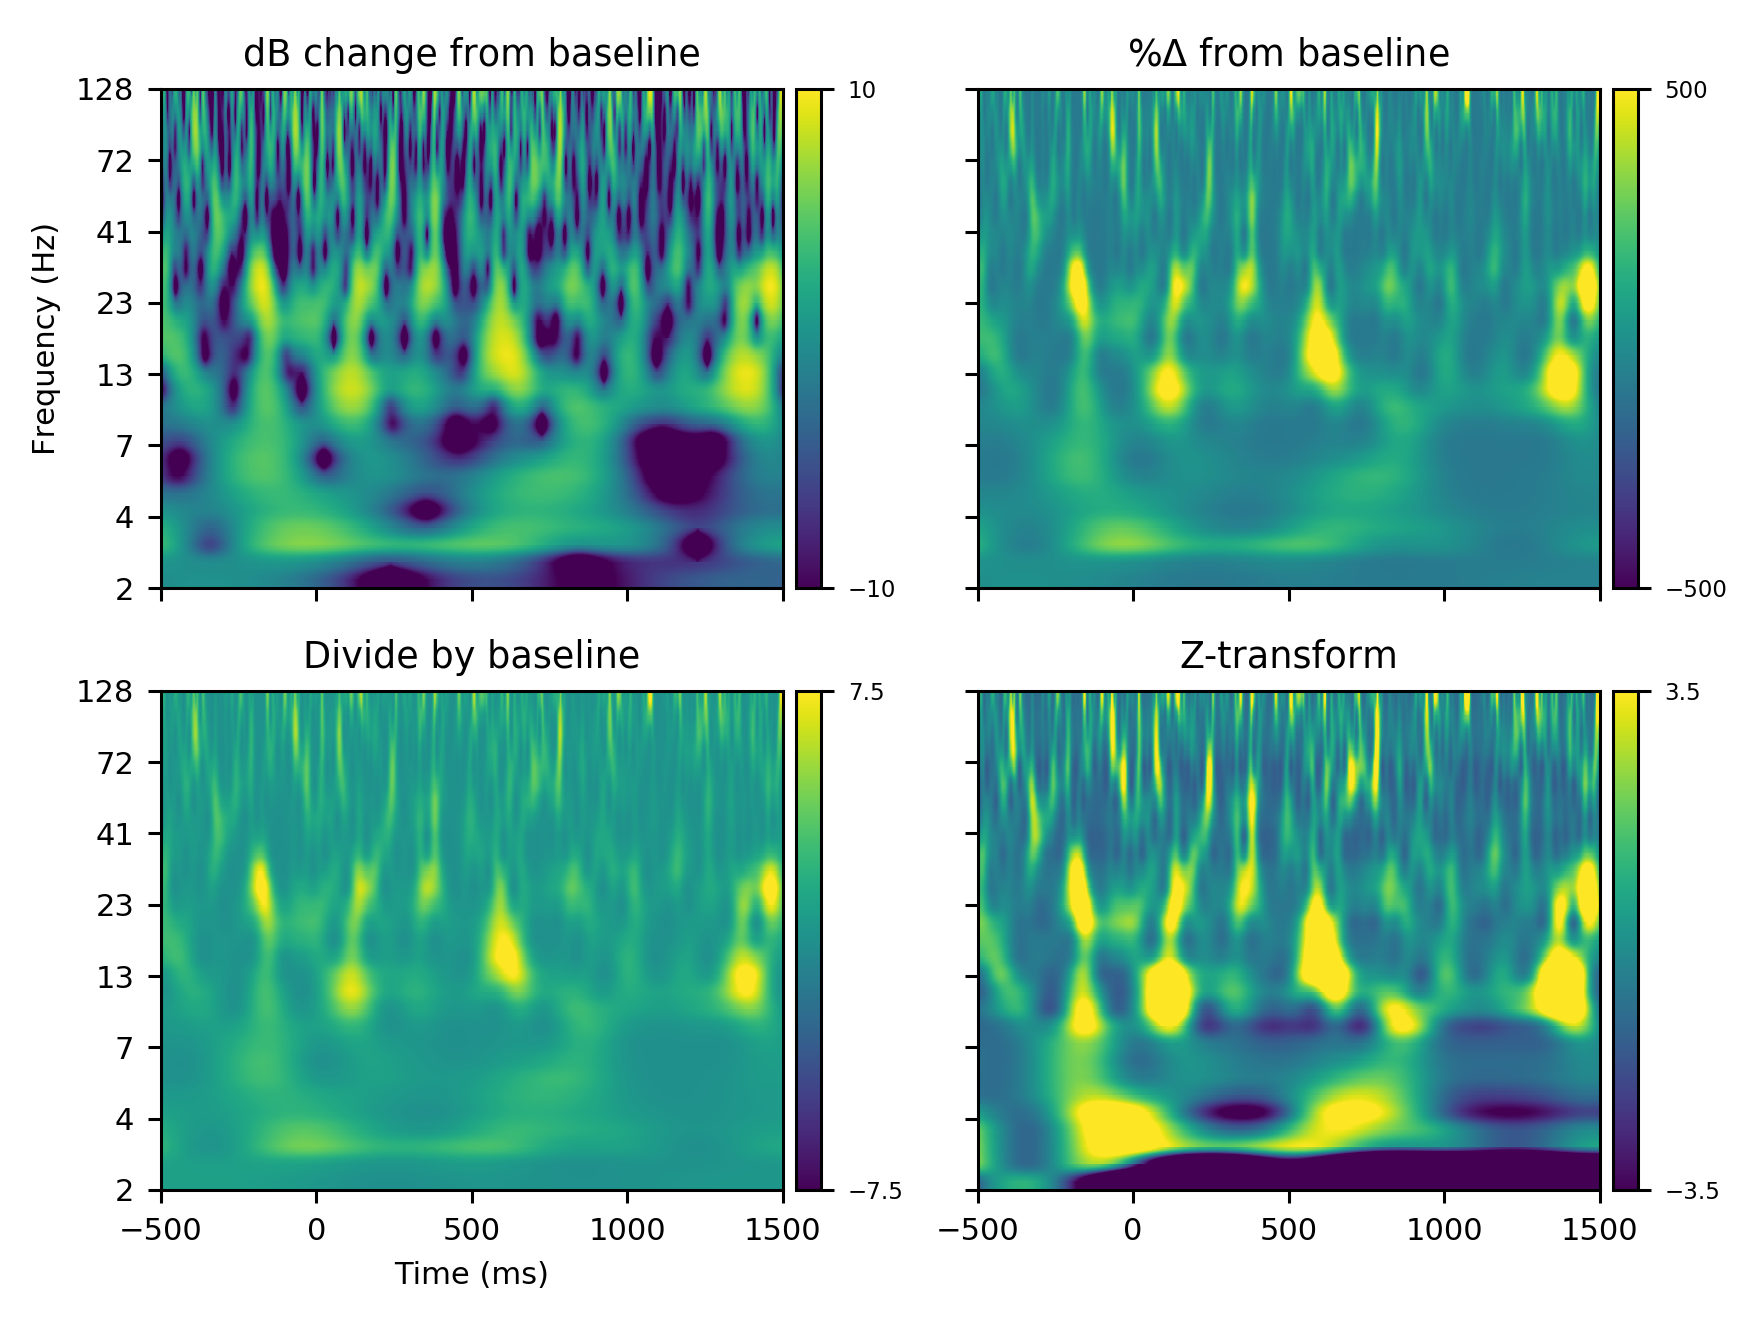

In [7]:
clims = [[-10, 10], [-500, 500], [-7.5, 7.5], [-3.5, 3.5]]
plot_list = [db_converted, pct_change, baseline_div, baseline_z]
titles = ['dB change from baseline', r'$\%\Delta$ from baseline', 'Divide by baseline', 'Z-transform']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

j = 0
for i in ax.flatten():
    i.imshow(plot_list[j], aspect='auto', 
             extent=[min(eeg_time), max(eeg_time), 30, 1],
             clim=(clims[j][0], clims[j][1]),
             interpolation='hamming'
            )
    i.set_xlim([-500, 1500])
    i.set_yticks(y_tick_skip)
    i.set_yticklabels([round(x) for x in freqs[y_tick_skip].tolist()])
    i.invert_yaxis()
    i.set_title(titles[j])
    
    m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=clims[j][0], vmax=clims[j][1]))
    cbar = fig.colorbar(m, ax=i, fraction=.04, pad=.02)
    cbar.set_ticks([clims[j][0], clims[j][1]])
    cbar.ax.tick_params(labelsize=6)
    j += 1

ax[0, 0].set_ylabel('Frequency (Hz)')
ax[1, 0].set_xlabel('Time (ms)')
fig.tight_layout()

### Figure 18.8

<IPython.core.display.Javascript object>


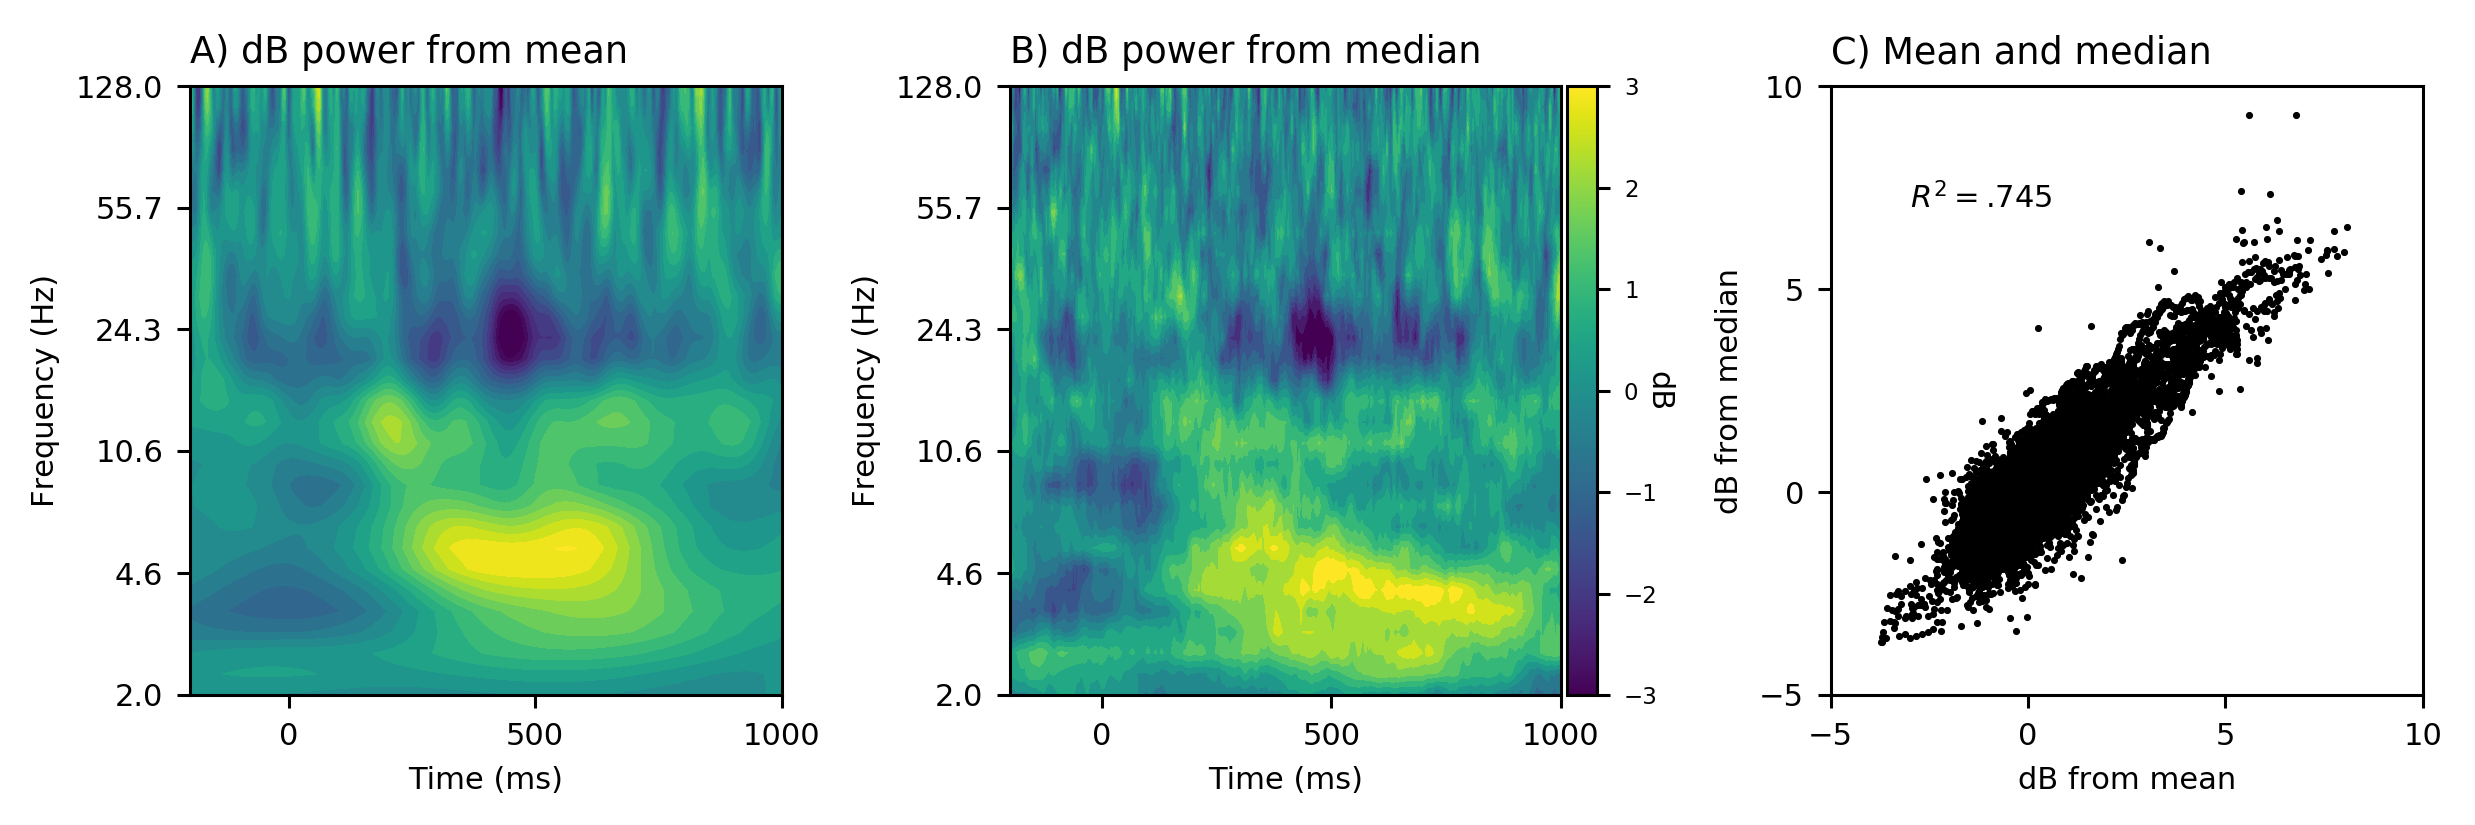

In [8]:
# Note y-axis values in textbook figure are incorrect

chan_to_plot = 'FCz'
chan_idx = np.squeeze(np.where(np.array(chan_names) == chan_to_plot))

# Initialize output time-frequency data
tf_data = np.zeros([2, len(freqs), np.shape(eeg_data)[1]])

# FFT parameters (use next power of 2)
n_data = np.shape(eeg_data)[1] * np.shape(eeg_data)[2]
n_conv = n_wavelet + n_data - 1
n_conv_pow2 = pow(2, np.ceil(np.log2(np.abs(n_conv))))

# FFT of data
fft_data = np.fft.fft(eeg_data[chan_idx, :, :].flatten(order='F'), n_conv_pow2)

for i in range(len(freqs)):
    
    # Create wavelet and compute FFT
    wavelet = (np.pi * freqs[i] * np.sqrt(np.pi))**-.5 * get_sine_wave(
        freqs[i], samp_rate, complex_wave=True) * gauss_win(
        freqs[i], samp_rate, n_cycles, normalize=True)
    fft_wavelet = np.fft.fft(wavelet, n_conv_pow2)
    
    # Run convolution
    temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_data, n_conv_pow2)
    temp_conv_res_fft = temp_conv_res_fft[0:n_conv]
    temp_conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
    conv_res_fft = temp_conv_res_fft.reshape(np.shape(eeg_data)[1], np.shape(eeg_data)[2], order='F')
    
    # Save single-trial data from one frequency band
    if i == 5:
        conv_dat = conv_res_fft
    
    # Place power data into time-frequency matrix
    tf_data[0, i, :] = np.mean(np.abs(conv_res_fft) ** 2, 1)
    tf_data[1, i, :] = np.median(np.abs(conv_res_fft) ** 2, 1)
    
# dB-correct time-frequency results
baseline_power_array = np.array([
    np.mean(tf_data[0, :, base_idx_start:base_idx_end], 1), # Mean index
    np.mean(tf_data[1, :, base_idx_start:base_idx_end], 1) # Median index
])

db_converted_array = np.array([
    10 * np.log10(tf_data[0, :, :] / baseline_power_array[0].reshape(np.shape(baseline_power)[0], 1)),
    10 * np.log10(tf_data[1, :, :] / baseline_power_array[1].reshape(np.shape(baseline_power)[0], 1))
])

r_sq = str(round(np.corrcoef(db_converted_array[0].flat, db_converted_array[1].flat)[0, 1] ** 2, 3))[1:]

yticks = np.round(np.logspace(np.log10(np.min(freqs)), np.log10(np.max(freqs)), 6), 1)

titles = ['mean', 'median']

fig, ax = plt.subplots(figsize=(9,3), nrows=1, ncols=3)

for i in range(np.shape(tf_data)[0]):
    
    ax[i].contourf(eeg_time, freqs, db_converted_array[i], levels=40, vmin=-3, vmax=3)
    ax[i].set_xlim([-200, 1000])
    ax[i].set_yscale('log')
    ax[i].set_xticks(np.linspace(0, 1000, 3))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Frequency (Hz)')
    ax[i].set_title(pos_to_char(i) + ') dB power from ' + titles[i], loc='left')
    ax[i].minorticks_off()

m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-3, vmax=3))
cbar = fig.colorbar(m, ax=ax[1], fraction=.06, pad=.01)
cbar.set_ticks(np.arange(-3, 4, 1))
cbar.ax.tick_params(labelsize=6)
cbar.set_label('dB', rotation=270)

ax[2].scatter(db_converted_array[0], db_converted_array[1], s=.75, color='black')
ax[2].set_xticks(np.linspace(-5, 10, 4))
ax[2].set_yticks(np.linspace(-5, 10, 4))
ax[2].set_xlabel('dB from mean')
ax[2].set_ylabel('dB from median')
ax[2].text(x=-3, y=7, s=r'$R^2 = $' + r_sq)
ax[2].set_title('C) Mean and median', loc='left')

fig.tight_layout()

### Figure 18.9

<IPython.core.display.Javascript object>


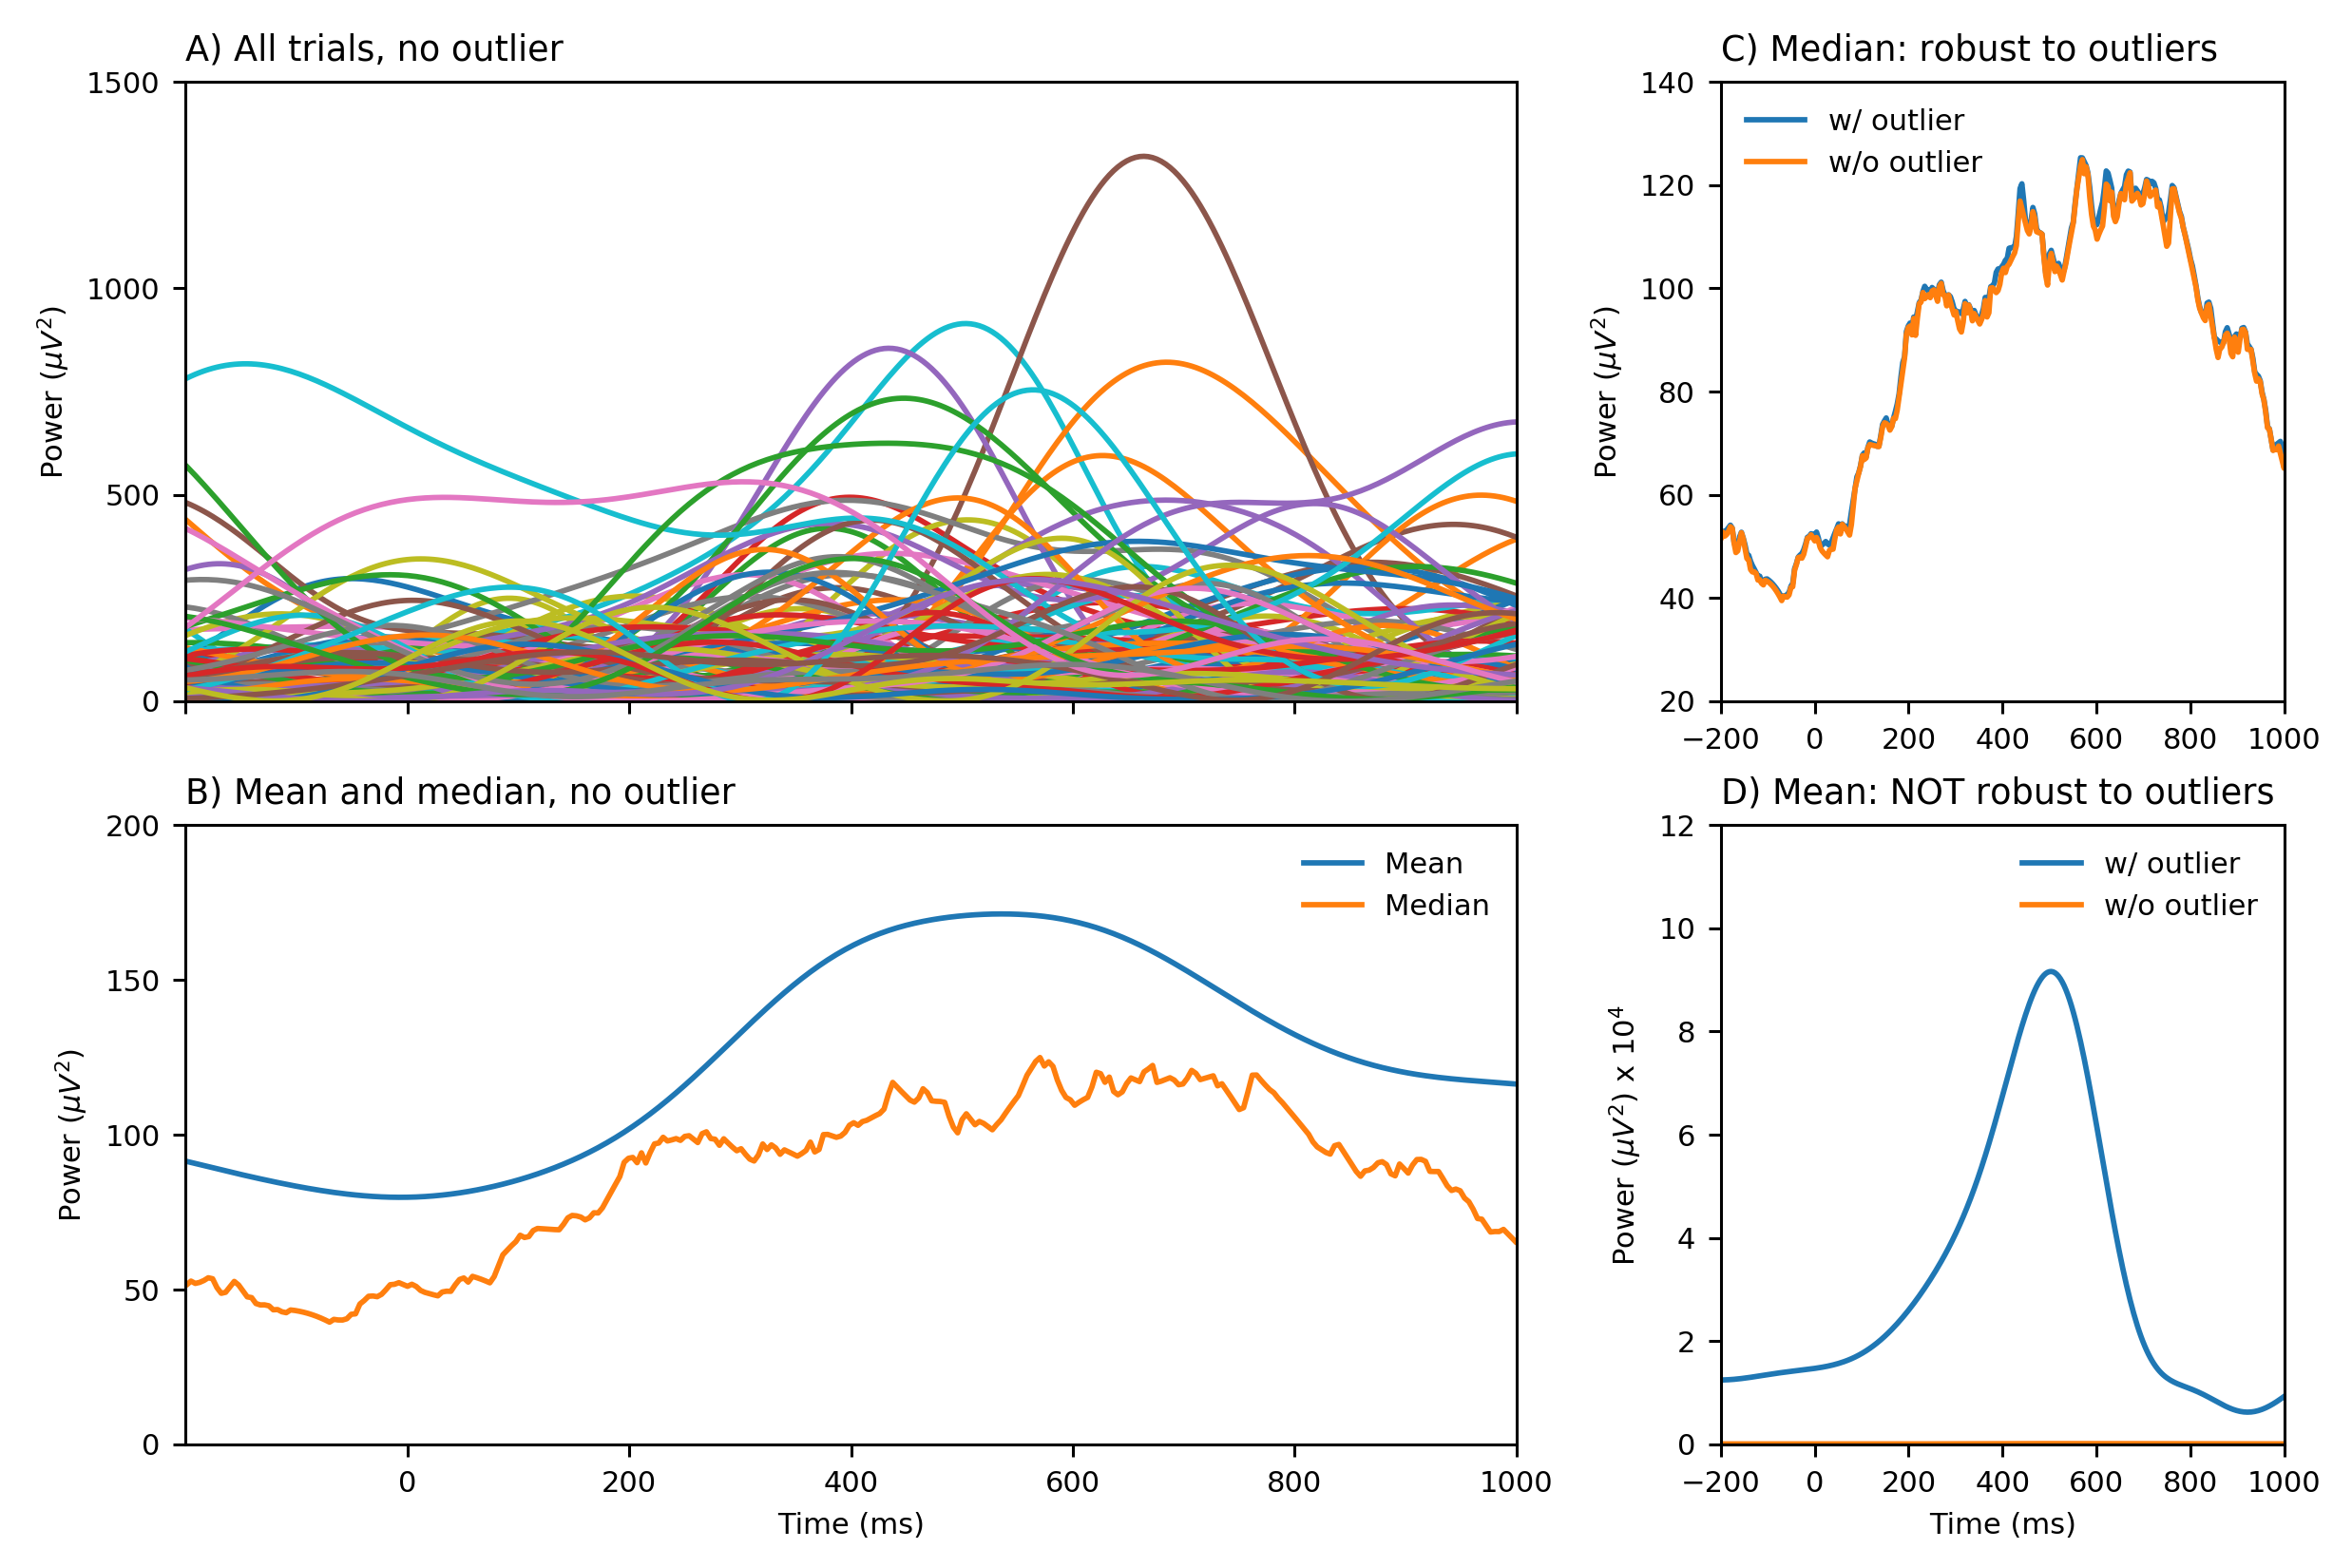

In [9]:
# Generate a synthetic outlier
conv_dat_outlier = np.column_stack((conv_dat, conv_dat[:, 9] * 100))
conv_dat_power =  np.abs(conv_dat) ** 2
conv_dat_power_outlier = np.abs(conv_dat_outlier) ** 2

# Set the figure and grid
fig = plt.figure(figsize=(9,6))
full_grid = fig.add_gridspec(2, 3)

# Set the subgrids
grid_A = full_grid[:, 0:2].subgridspec(2, 1)
grid_B = full_grid[:, 2].subgridspec(2, 1)

ax_A00 = fig.add_subplot(grid_A[0, 0])
ax_A00.plot(eeg_time, conv_dat_power)
ax_A00.set_xlim([-200, 1000])
ax_A00.set_ylim([0, 1500])
ax_A00.set_xticklabels([])
ax_A00.set_ylabel(r'Power ($\mu$$V^2$)')
ax_A00.set_yticks(np.linspace(0, 1500, 4))
ax_A00.set_title('A) All trials, no outlier', loc='left')

ax_A10 = fig.add_subplot(grid_A[1, 0])
ax_A10.plot(eeg_time, np.mean(conv_dat_power, 1))
ax_A10.plot(eeg_time, np.median(conv_dat_power, 1))
ax_A10.set_xlim([-200, 1000])
ax_A10.set_ylim([0, 200])
ax_A10.set_xticks(np.linspace(0, 1000, 6))
ax_A10.set_yticks(np.linspace(0, 200, 5))
ax_A10.set_xlabel('Time (ms)')
ax_A10.set_ylabel(r'Power ($\mu$$V^2$)')
ax_A10.set_title('B) Mean and median, no outlier', loc='left')
ax_A10.legend(labels=['Mean', 'Median'], frameon=False)

ax_B00 = fig.add_subplot(grid_B[0, 0])
ax_B00.plot(eeg_time, np.median(conv_dat_power_outlier, 1))
ax_B00.plot(eeg_time, np.median(conv_dat_power, 1))
ax_B00.set_xlim([-200, 1000])
ax_B00.set_ylim([20, 140])
ax_B00.set_ylabel(r'Power ($\mu$$V^2$)')
ax_B00.set_title('C) Median: robust to outliers', loc='left')
ax_B00.legend(labels=['w/ outlier', 'w/o outlier'], frameon=False)

ax_B10 = fig.add_subplot(grid_B[1, 0])
ax_B10.plot(eeg_time, np.mean(conv_dat_power_outlier, 1) / 10 ** 4)
ax_B10.plot(eeg_time, np.mean(conv_dat_power, 1) / 10 ** 4)
ax_B10.set_xlim([-200, 1000])
ax_B10.set_ylim([0, 12])
ax_B10.set_xlabel('Time (ms)')
ax_B10.set_ylabel(r'Power ($\mu$$V^2$) x $10^4$')
ax_B10.set_title('D) Mean: NOT robust to outliers', loc='left')
ax_B10.legend(labels=['w/ outlier', 'w/o outlier'], frameon=False)

full_grid.tight_layout(fig)

### Figure 18.10

<IPython.core.display.Javascript object>


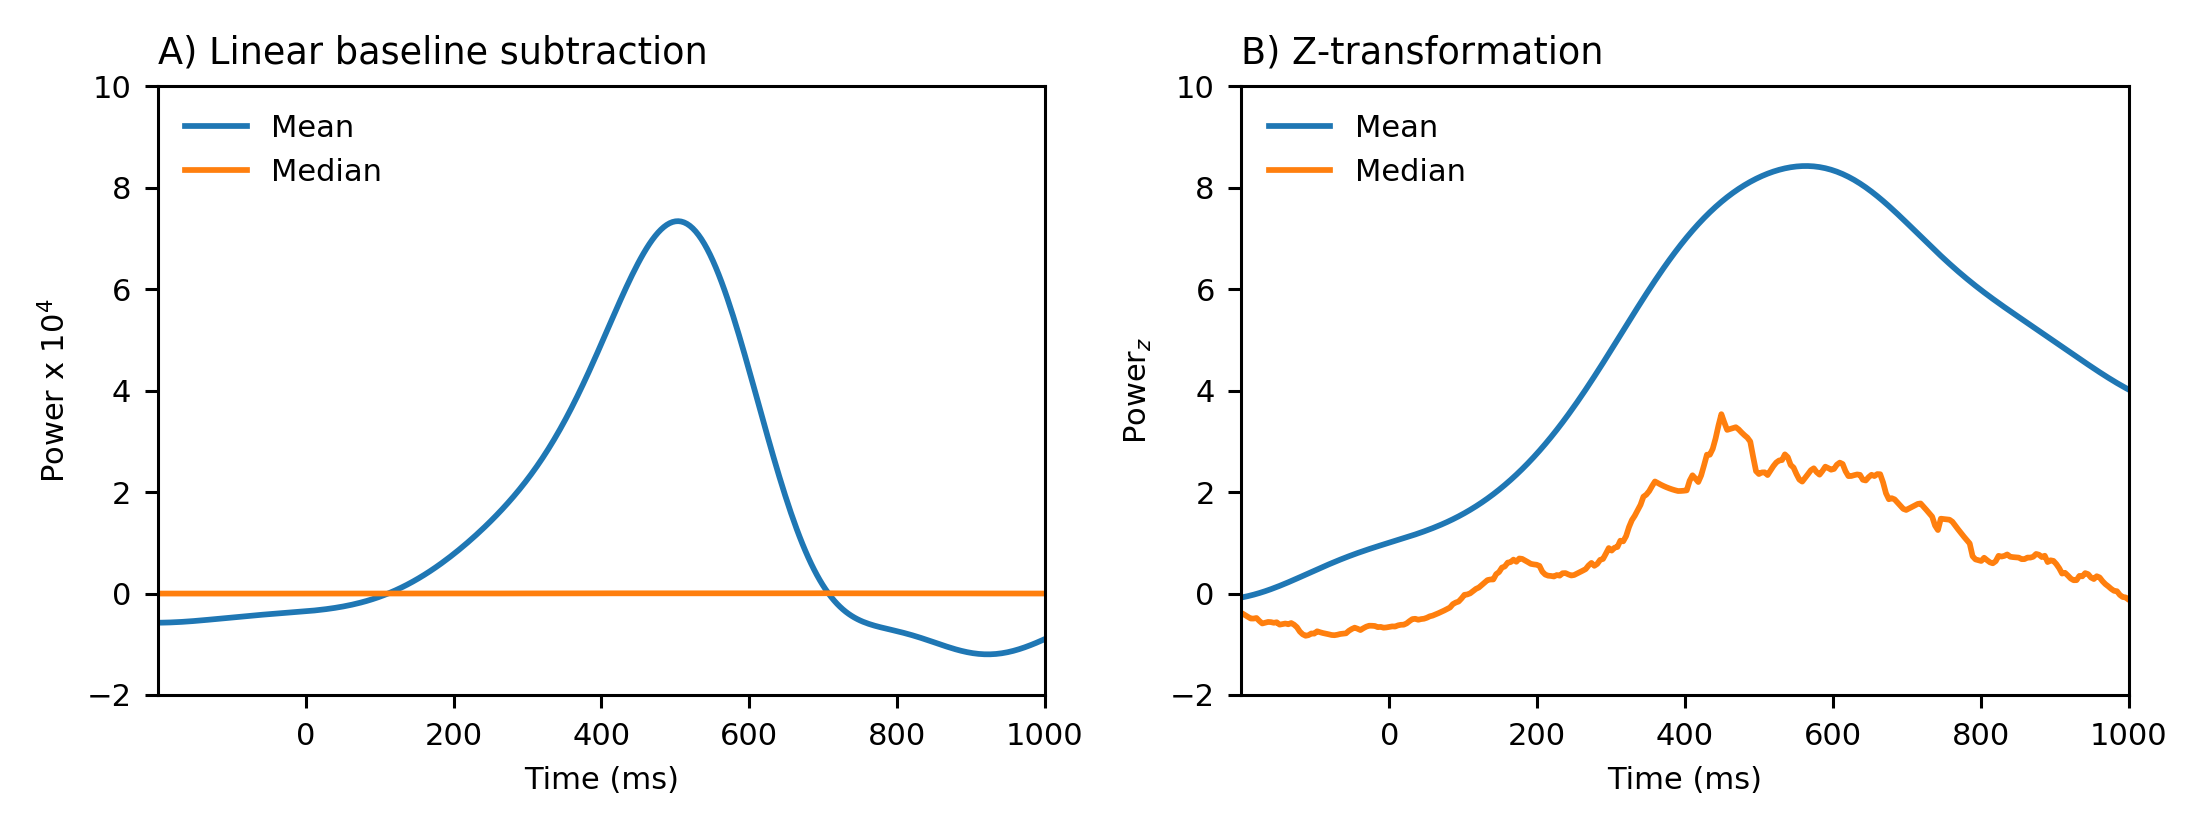

In [10]:
# Single-trial linear baseline correction
baseline = conv_dat_power_outlier[base_idx_start:base_idx_end, :]
conv_dat_b = conv_dat_power_outlier - np.mean(baseline, 0)

# Single-trial Z-score
conv_dat_z = conv_dat_b / np.std(baseline, 0, ddof=1)

# Single-trial log10
conv_dat_l = np.log10(conv_dat_power_outlier)
conv_dat_z[99,99]

plot_array = np.array([conv_dat_b, conv_dat_z])
titles = ['A) Linear baseline subtraction', 'B) Z-transformation']

fig, ax = plt.subplots(figsize=(8,3), ncols=2)

j = 0
for i in ax.flatten():
    if j == 0:
        scalar = 10 ** 4
        lab_str = r' x $10^4$'
    else:
        scalar = 1
        lab_str = r'$_{z}$'
    i.plot(eeg_time, np.mean(plot_array[j] / scalar, 1))
    i.plot(eeg_time, np.median(plot_array[j] / scalar, 1))
    i.set_xlim([-200, 1000])
    i.set_ylim([-2, 10])
    i.set_xticks(np.linspace(0, 1000, 6))
    i.set_xlabel('Time (ms)')
    i.set_ylabel('Power' + lab_str)
    i.set_title(titles[j], loc='left')
    i.legend(labels=['Mean', 'Median'], frameon=False, loc='upper left')
    j += 1
    
fig.tight_layout()

### Figure 18.12

Let $\mu$ be mean power across trials, $\sigma$ standard deviation of power across trials:

The signal-to-noise ratio (SNR) for time-frequency data is:

$$\textrm{SNR}_{tf} = \frac{\mu_{tf}}{\sigma_{tf}}$$

<IPython.core.display.Javascript object>


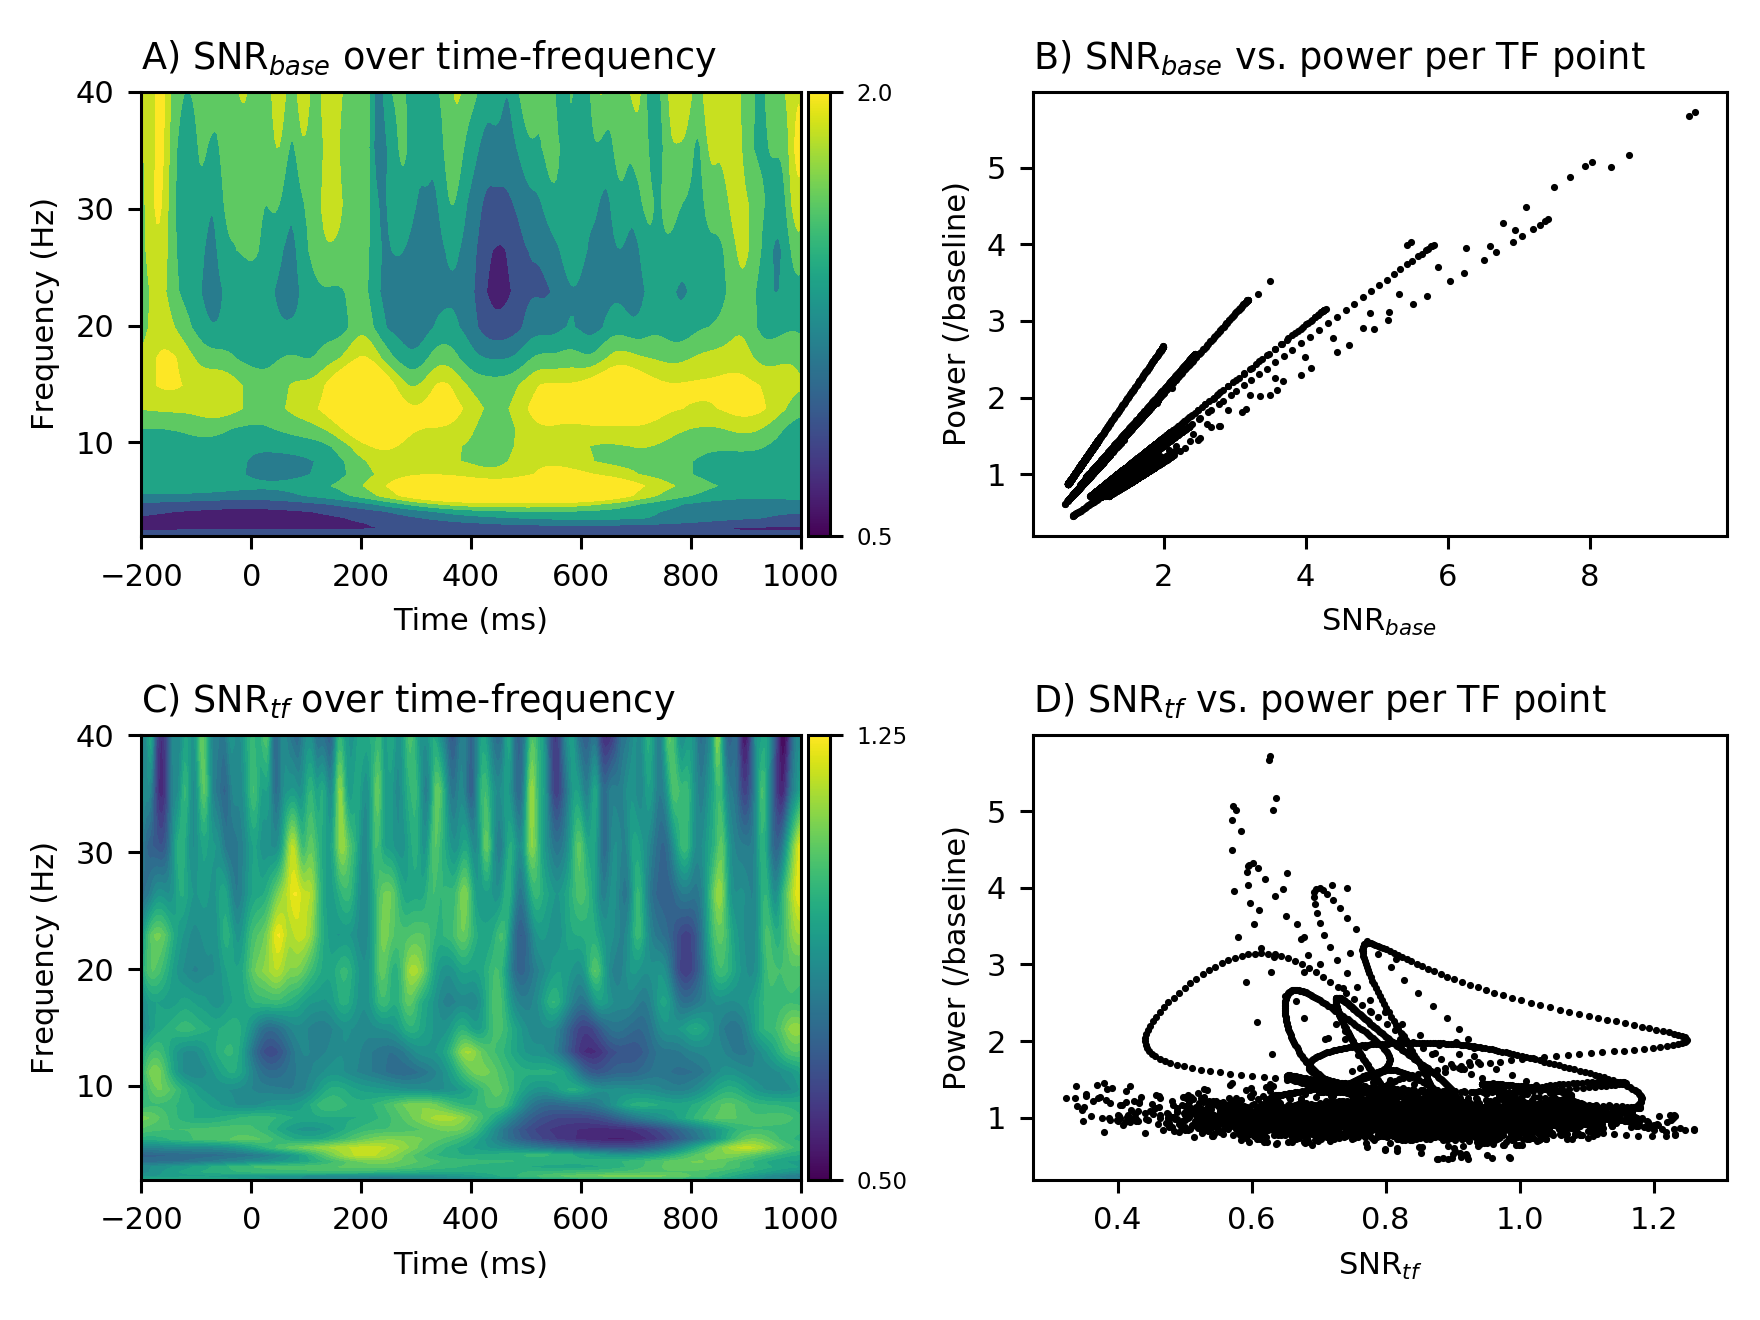

In [11]:
# There is a distinction between the textbook, which included 
# a bug where the baseline-divided power was based on a single trial. 
# Cohen notes this bug in his code.

# Initialize output arrays
snr_bs = np.zeros([len(freqs), np.shape(eeg_data)[1]])
snr_tf = snr_bs.copy()
tf = snr_bs.copy()

for i in range(len(freqs)):
    
    # Create wavelet and compute FFT
    wavelet = get_sine_wave(freqs[i], samp_rate, complex_wave=True) * gauss_win(
        freqs[i], samp_rate, n_cycles, normalize=True)
    fft_wavelet = np.fft.fft(wavelet, n_conv_pow2)
    
    # Run convolution
    temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_data, n_conv_pow2) * np.sqrt(n_cycles / (2 * np.pi * freqs[i]))
    temp_conv_res_fft = temp_conv_res_fft[0:n_conv]
    temp_conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
    conv_res_fft = temp_conv_res_fft.reshape(np.shape(eeg_data)[1], np.shape(eeg_data)[2], order='F')
    
    # Get power from activity
    activity = np.abs(conv_res_fft) ** 2
    
    # Extract SNR in two ways
    snr_tf[i, :] = np.mean(activity, 1) / np.std(activity, 1, ddof=1)
    snr_bs[i, :] = np.mean(activity, 1) / np.std(np.mean(
        np.abs(conv_res_fft[base_idx_start:base_idx_end, :]) ** 2, 0), 0, ddof=1)
    
    # Extract trial-averaged power
    tf[i, :] = np.mean(activity, 1)
    
baseline_power = np.mean(tf[:, base_idx_start:base_idx_end], 1)
baseline_div = tf / baseline_power.reshape(np.shape(baseline_power)[0], 1)

fig, ax = plt.subplots(nrows=2, ncols=2)

j = 0
for i in ax.flatten():
    if j < 2:
        dat = snr_bs
        cmax = 2 
        lab = r'$_{base}$ '
    else:
        dat = snr_tf
        cmax = 1.25
        lab = r'$_{tf}$ '
    if j % 2 == 0:
        i.contourf(eeg_time, freqs, dat, levels=40, vmin=.5, vmax=cmax)
        i.set_xlim([-200, 1000])
        i.set_ylim([freqs[0], 40])
        i.set_xlabel('Time (ms)')
        i.set_ylabel('Frequency (Hz)')
        i.set_title(pos_to_char(j) + ') SNR' + lab + 'over time-frequency', loc='left')
        m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=.5, vmax=cmax))
        cbar = fig.colorbar(m, ax=i, fraction=.04, pad=.01)
        cbar.set_ticks([.5, cmax])
        cbar.ax.tick_params(labelsize=6)
    else:
        i.scatter(dat[0:sub:3].flatten(order='F'), baseline_div[0:sub:3].flatten(order='F'), s=.75, color='black')
        i.set_xlabel('SNR' + lab)
        i.set_ylabel('Power (/baseline)')
        i.set_title(pos_to_char(j) + ') SNR' + lab + 'vs. power per TF point', loc='left')
    j += 1
    
fig.tight_layout()

### Figure 18.13

<IPython.core.display.Javascript object>


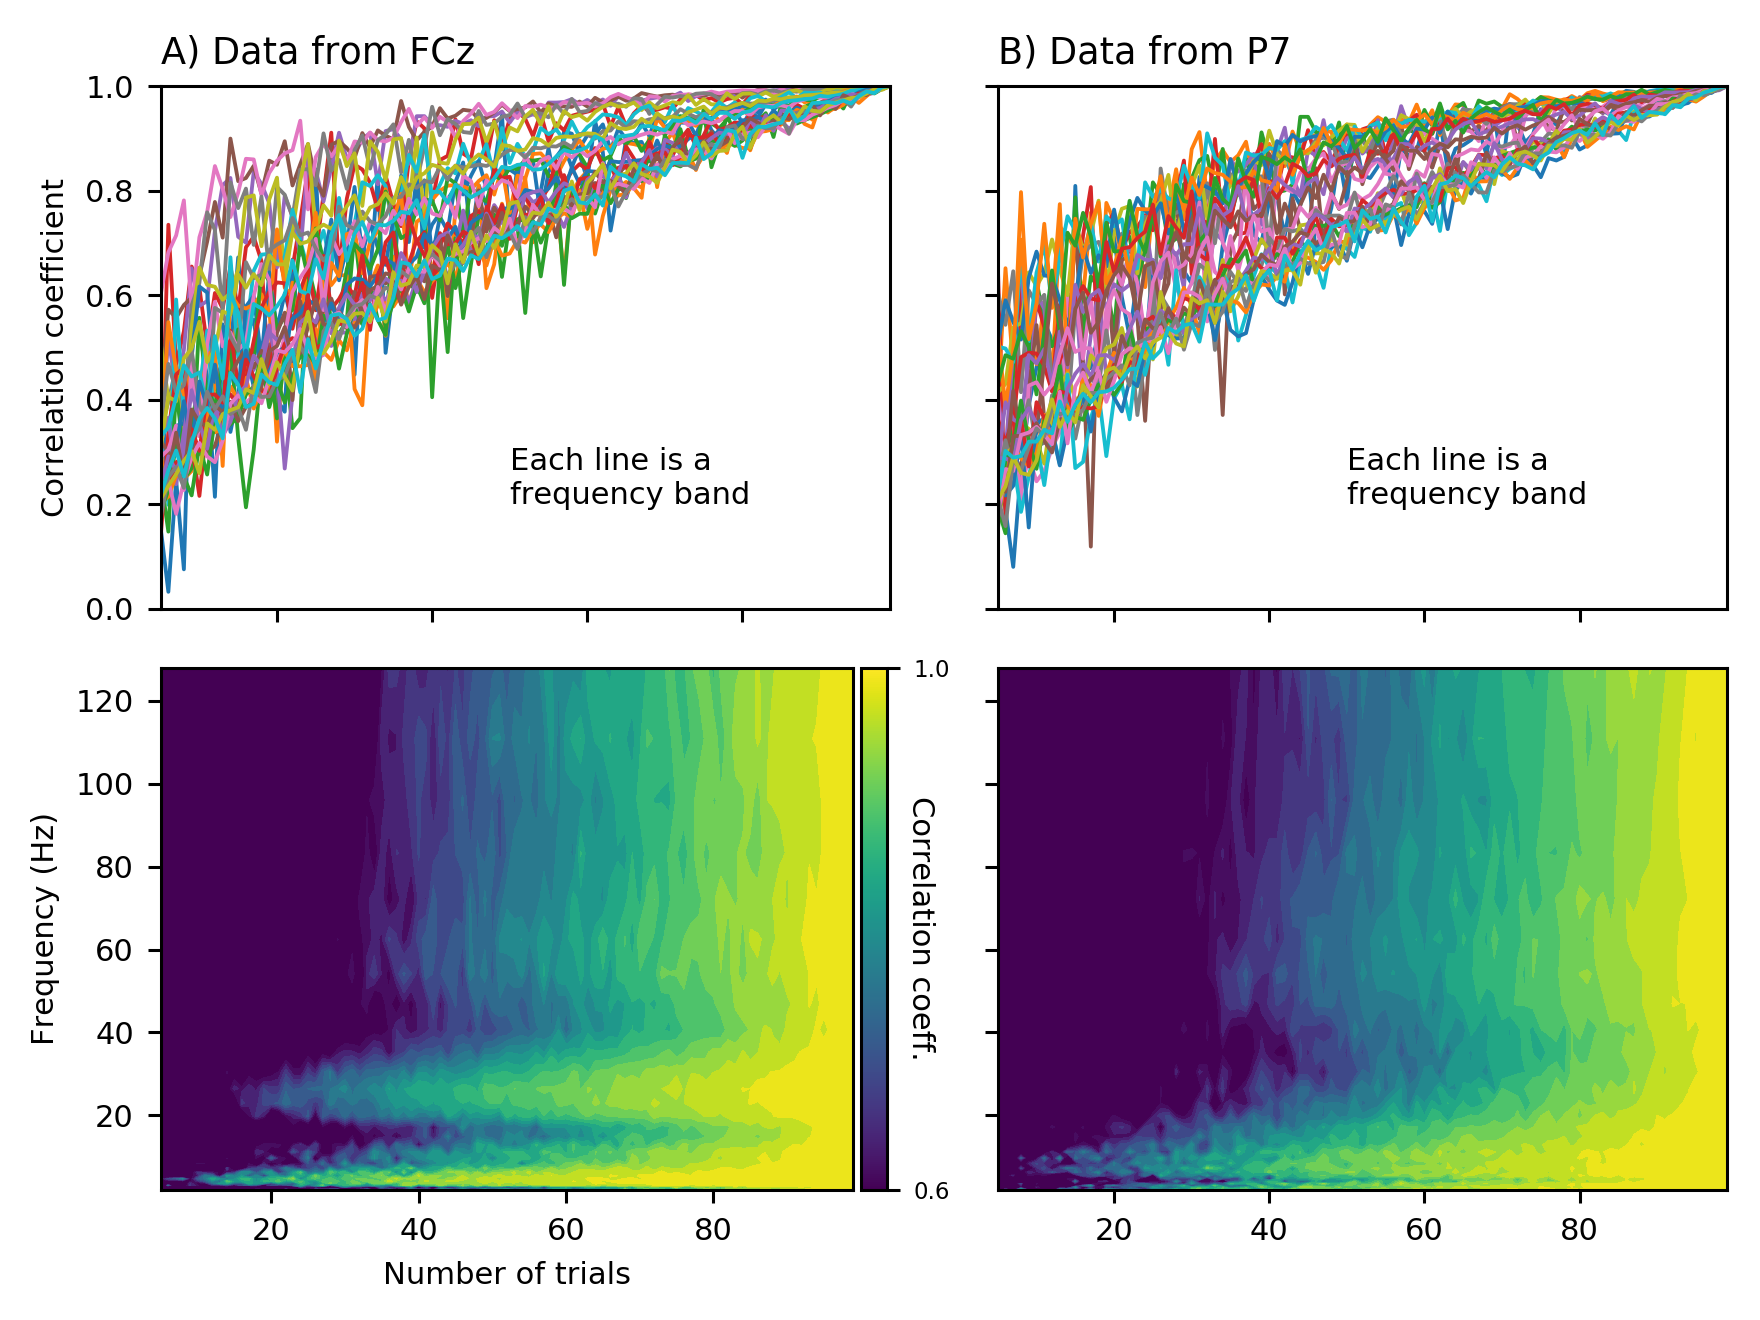

In [12]:
# Trials are selected randomly for this figure so they will not reproduce
# identical figures as the textbook, although they will display similar
# patterns. 

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)

# Set parameters
chans_to_plot = ['FCz', 'P7']
times = [-200, 1200] # ms
iterations = 10

# Loop through channels
for c in range(len(chans_to_plot)):
    
    chan_idx = np.squeeze(np.where(np.array(chan_names) == chans_to_plot[c]))
    fft_data = np.fft.fft(eeg_data[chan_idx, :, :].flatten(order='F'), n_conv_pow2)
    time_idx = find_nearest(eeg_time, times)
    
    # Initialize output array
    power_by_trial_freq = np.zeros([len(freqs), np.shape(eeg_data)[2]])
    
    # Loop through frequencies
    for f in range(len(freqs)):
        
        # Create wavelet and compute FFT
        wavelet = get_sine_wave(freqs[f], samp_rate, complex_wave=True) * gauss_win(
            freqs[f], samp_rate, n_cycles, normalize=True)
        fft_wavelet = np.fft.fft(wavelet, n_conv_pow2)
    
        # Run convolution
        temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_data, n_conv_pow2) * np.sqrt(n_cycles / (2 * np.pi * freqs[f]))
        temp_conv_res_fft = temp_conv_res_fft[0:n_conv]
        temp_conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
        conv_res_fft = np.abs(temp_conv_res_fft.reshape(np.shape(eeg_data)[1], np.shape(eeg_data)[2], order='F')) ** 2
        
        # Average over all trials and then normalize
        temp_template = np.mean(conv_res_fft[time_idx[0]:time_idx[1] + 1, :], 1)
        template = (temp_template - np.mean(temp_template)) / np.std(temp_template, ddof=1)
        
        # Loop through iterations
        for i in range(iterations):
            
            # Loop through number of trials
            for t in range(4, np.shape(eeg_data)[2]):
                
                # Randomly select trials
                trial_idx = np.random.choice(np.shape(eeg_data)[2], t + 1, replace=False)
                
                # Compute power time series from the random selection of trials and then normalize
                temp_dat = np.mean(conv_res_fft[time_idx[0]:time_idx[1] + 1, trial_idx], 1)
                dat = (temp_dat - np.mean(temp_dat)) / np.std(temp_dat, ddof=1)
                
                # Compute Pearson correlation w/ least squares linear algebra
                power_by_trial_freq[f, t] = power_by_trial_freq[f, t] + np.dot(dat / np.dot(dat, dat), template)
                
    freq_by_trial = power_by_trial_freq / iterations
    
    # Plot results
    ax[0, c].plot(range(5, np.shape(eeg_data)[2] + 1), freq_by_trial[:, 4:].T, linewidth=1)
    ax[0, c].set_xticks(np.linspace(20, 80, 4))
    ax[0, c].set_yticks(np.linspace(0, 1, 6))
    ax[0, c].set_ylim([0, 1])
    ax[0, c].set_title(pos_to_char(c) + ') Data from ' + chans_to_plot[c], loc='left')
    ax[0, c].text(x=50, y=.2, s='Each line is a \nfrequency band')
    ax[1, c].contourf(range(5, np.shape(eeg_data)[2] + 1), freqs, freq_by_trial[:, 4:], levels=40, vmin=.6, vmax=1)
    ax[1, c].set_yticks(np.linspace(20, 120, 6))

m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=.6, vmax=1))
cbar = fig.colorbar(m, ax=ax[1, 0], fraction=.04, pad=.01)
cbar.set_ticks([.6, 1])
cbar.ax.tick_params(labelsize=6)
cbar.set_label('Correlation coeff.', rotation=270, labelpad=-4)
ax[0, 0].set_ylabel('Correlation coefficient')
ax[0, 1].set_yticklabels([])
ax[1, 0].set_xlabel('Number of trials')
ax[1, 0].set_ylabel('Frequency (Hz)')
ax[1, 1].set_yticklabels([])

fig.tight_layout()